In [1]:
# must go first 
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.3)
import folium

# system packages 
import os, sys
import warnings
warnings.filterwarnings('ignore')

# basic wrangling 
import numpy as np
import pandas as pd

# eda tools 
import pivottablejs
import missingno as msno
import pandas_profiling

# interactive 
import ipywidgets as widgets

# more technical eda
import sklearn
import scipy

In [2]:
sys.path.append('../../scripts/')

In [3]:
from aqua_helper import time_slice, country_slice, time_series, simple_regions, subregion, variable_slice

In [4]:
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
              'axes.labelsize':16,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

http://www.fao.org/nr/water/aquastat/data/query/index.html

In [5]:
data = pd.read_csv('aquastat.csv.gzip', compression='gzip')

# simplify regions
data.region = data.region.apply(lambda x: simple_regions[x])

# remove exploitable fields and national rainfall index
data = data.loc[~data.variable.str.contains('exploitable'),:]
data = data.loc[~(data.variable=='national_rainfall_index')]

Subset for cross-sectional analysis

In [6]:
recent = time_slice(data, '2013-2017')

# Exploring *population*

## Cross-section
For numerical data, look at: 

* *Location*: 均值，中位数，模式，四分位
* *Spread*: 标准差、方差、范围、间距范围
* *Shape*: 偏度、峰度

### Location and spread of the data

Are minimum/maximum values feasible? 

In [7]:
recent[['total_pop', 'urban_pop', 'rural_pop']].describe().astype(int)

2013-2017,total_pop,urban_pop,rural_pop
count,199,199,199
mean,36890,19849,17040
std,140720,69681,77461
min,0,0,-98
25%,1368,822,500
50%,7595,3967,2404
75%,25088,11656,10677
max,1407306,805387,891112


Rural population is negative... what does that mean? 

In [8]:
recent.sort_values('rural_pop')[['total_pop','urban_pop','rural_pop']].head()

2013-2017,total_pop,urban_pop,rural_pop
country,,,
Qatar,2235.00,2333.00,-98.00
Singapore,5604.00,5619.00,-15.00
Monaco,37.73,38.32,-0.59
Holy See,0.80,0.80,0.00
Nauru,10.22,10.12,0.10


`Rural population = Total population - urban population`

In [9]:
time_series(data, 'Qatar', 'total_pop').join(time_series(data, 'Qatar', 'urban_pop')).join(time_series(data, 'Qatar', 'rural_pop'))

,total_pop,urban_pop,rural_pop
year_measured,,,
1962,56.19,48.39,7.80
1967,86.16,75.48,10.68
1972,130.40,115.60,14.80
1977,182.40,162.40,20.00
1982,277.20,248.60,28.60
1987,423.30,385.40,37.90
1992,489.70,459.10,30.60
1997,528.20,506.50,21.70
2002,634.40,608.90,25.50


We should also start suspecting that the data is skewed:
* 50% quartile much closer to 25% or 75% in value
* Large difference between mean and 50% 

### Shape of the data
* 数据分布是倾斜的吗？
* 有异常值吗？它们可行吗？ 
* 有不连续的吗? 

In [10]:
recent[['total_pop', 'urban_pop', 'rural_pop']].describe().astype(int)

2013-2017,total_pop,urban_pop,rural_pop
count,199,199,199
mean,36890,19849,17040
std,140720,69681,77461
min,0,0,-98
25%,1368,822,500
50%,7595,3967,2404
75%,25088,11656,10677
max,1407306,805387,891112


是的，看起来人口是倾斜的。让我们尝试计算偏度和峰度和绘制直方图显示。

<img src="figures/f1.png" alt="FAO" width="400" align="right">
<img src="figures/f2.png" alt="FAO" width="290" align="right">
### [Skewness and kurtosis](http://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)

左偏：均值<中位数

*Skewness:* measure of lack of symmetry. 

*Kurtosis:* measure of whether the data are heavily tailed relative to the normal distribution. 

In [11]:
recent[['total_pop', 'urban_pop', 'rural_pop']].apply(scipy.stats.skew)

2013-2017
total_pop    8.519379
urban_pop    8.545690
rural_pop    9.490029
dtype: float64

正态分布的偏度应为零。负偏度表示偏左，正偏表示右偏。

In [12]:
recent[['total_pop', 'urban_pop', 'rural_pop']].apply(scipy.stats.kurtosis)

2013-2017
total_pop    76.923725
urban_pop    85.499659
rural_pop    95.838930
dtype: float64

峰度也是一个正态分布和零只能是积极的。我们肯定有一些异常值！

### The trusty histogram

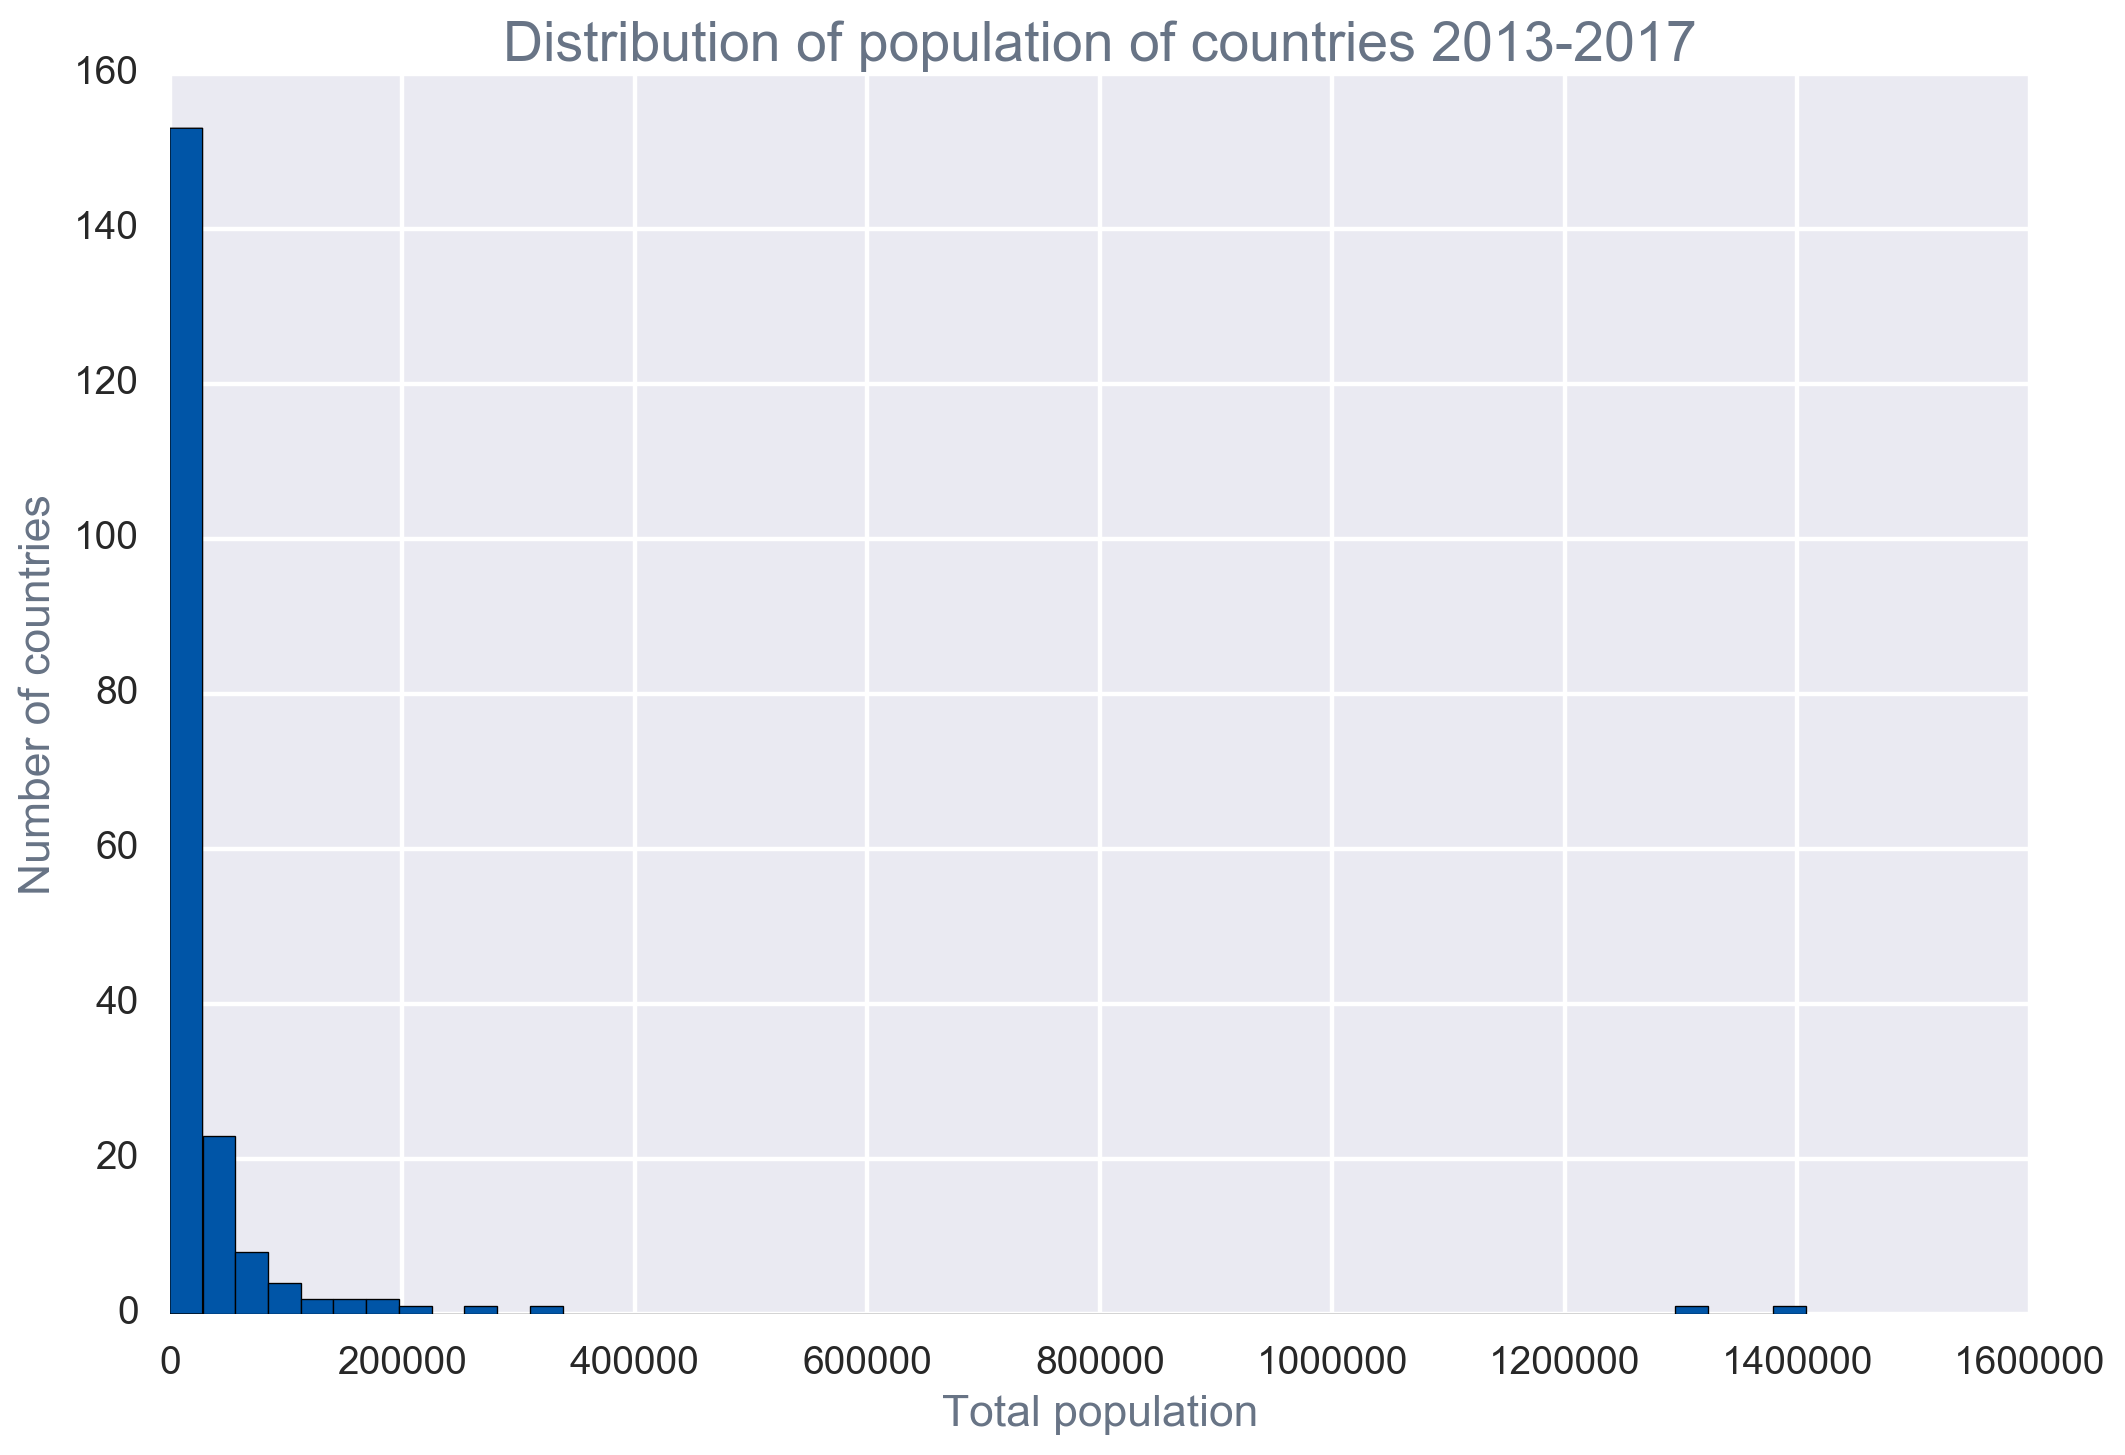

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(recent.total_pop.values, bins=50);
ax.set_xlabel('Total population');
ax.set_ylabel('Number of countries');
ax.set_title('Distribution of population of countries 2013-2017');

Let's functionalize this so we can use it again.

Yup, definitely skewed. Why is this a problem?
* Many models assume a normal (bell-like) curve
* It is difficult to differentiate observations when skewed (~150/199 look all the same!) 



解决方法是什么？通常，使用LOG转换将使变量更为正常。

### Log transform


<img src="figures/f3.png" alt="FAO" width="590" >
对数变换是数据变换的一种常用方式，数据变换的目的在于使数据的呈现方式接近我们所希望的前提假设，从而更好的进行统计推断。

<img src="figures/f4.png" alt="FAO" width="590" >
左边是正常数据，可以看到随着时间推进，电力生产也变得方差越来越大，即越来越不稳定。
这种情况下常有的分析假设经常就不会满足（误差服从独立同分布的正态分布，时间序列要求平稳）。

理论上，我们将这类问题抽象成这种模型，即分布的标准差与其均值线性相关

In [14]:
recent[['total_pop']].apply(np.log).apply(scipy.stats.skew)
# recent[['total_pop']].apply(np.log).apply(scipy.stats.skewtest)

2013-2017
total_pop   -0.899063
dtype: float64

它确实减少了偏斜，但并没有使它消失。峰度如何？

In [15]:
recent[['total_pop']].apply(np.log).apply(scipy.stats.kurtosis)
# recent[['total_pop']].apply(np.log).apply(scipy.stats.kurtosistest)

2013-2017
total_pop    1.086877
dtype: float64

再次，它减少了，但并没有摆脱峰度。

In [16]:
def plot_hist(df, variable, bins=20, xlabel=None, by=None,
              ylabel=None, title=None, logx=False, ax=None):

    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
    if logx:
        if df[variable].min() <=0:
            df[variable] = df[variable] - df[variable].min() + 1
            print('Warning: data <=0 exists, data transformed by %0.2g before plotting' % (- df[variable].min() + 1))
        
        bins = np.logspace(np.log10(df[variable].min()),
                           np.log10(df[variable].max()), bins)
        ax.set_xscale("log")

    ax.hist(df[variable].dropna().values, bins=bins);
    
    if xlabel:
        ax.set_xlabel(xlabel);
    if ylabel:
        ax.set_ylabel(ylabel);
    if title:
        ax.set_title(title);
    
    return ax

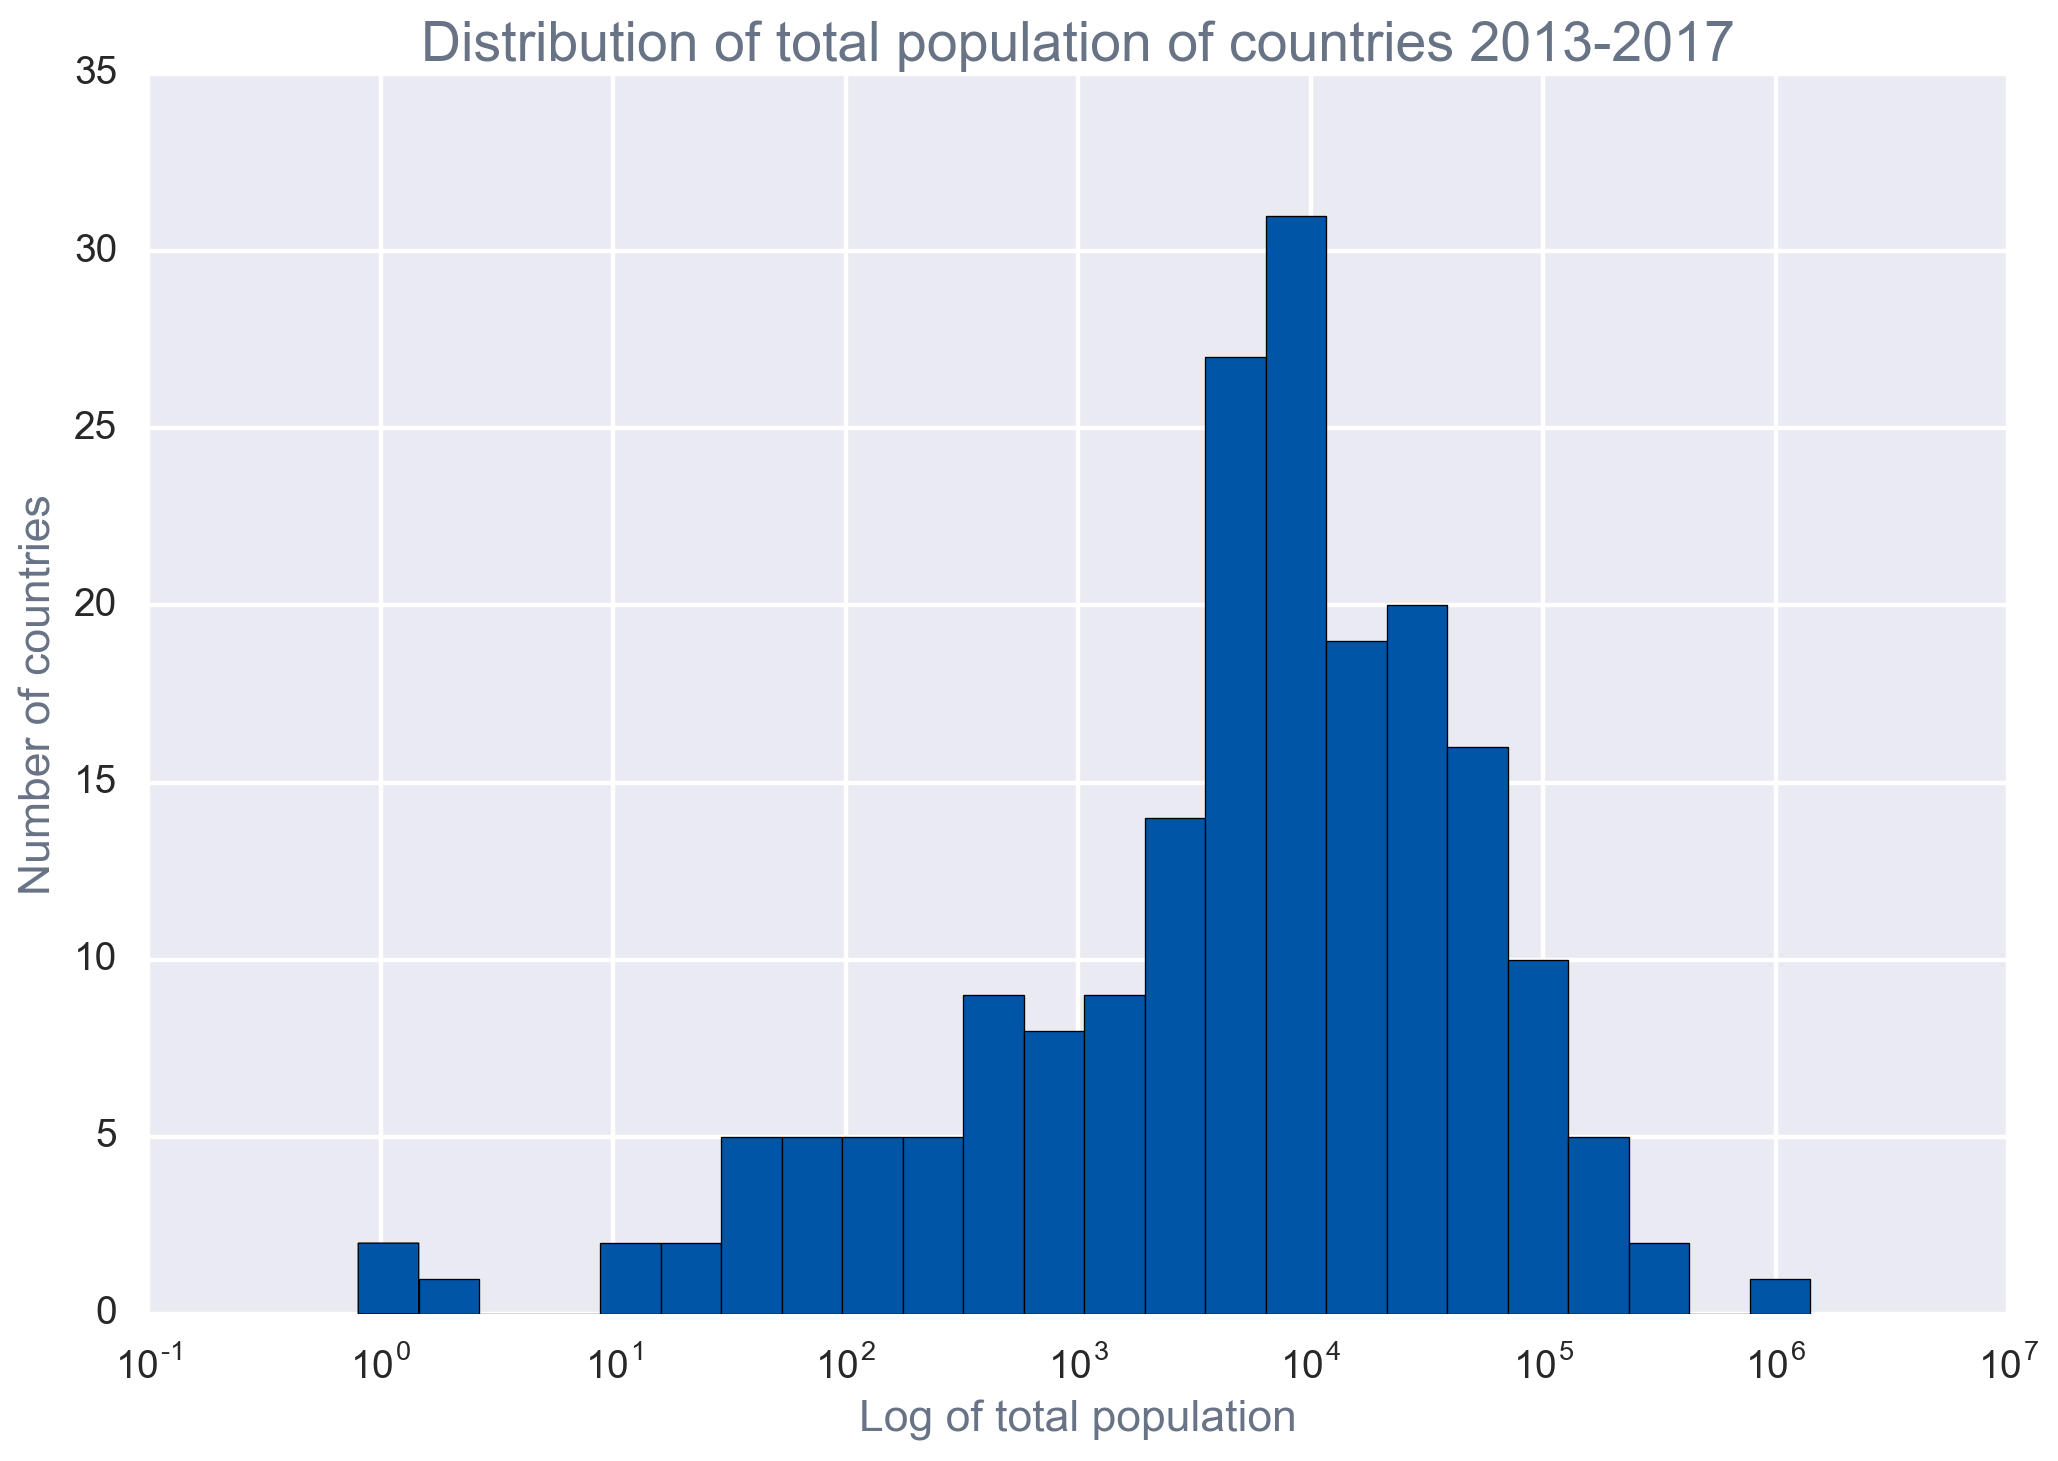

In [17]:
plot_hist(recent, 'total_pop', bins=25, logx=True, 
          xlabel='Log of total population', ylabel='Number of countries',
          title='Distribution of total population of countries 2013-2017');

### Normalization

In [18]:
recent['population_density'] = recent.total_pop.divide(recent.total_area)

## Over time

### One country

Check a sample we have familiarity with. 
* Are the units what we think they are? 
* Does this behavior correspond with our pre-existing knowledge? 

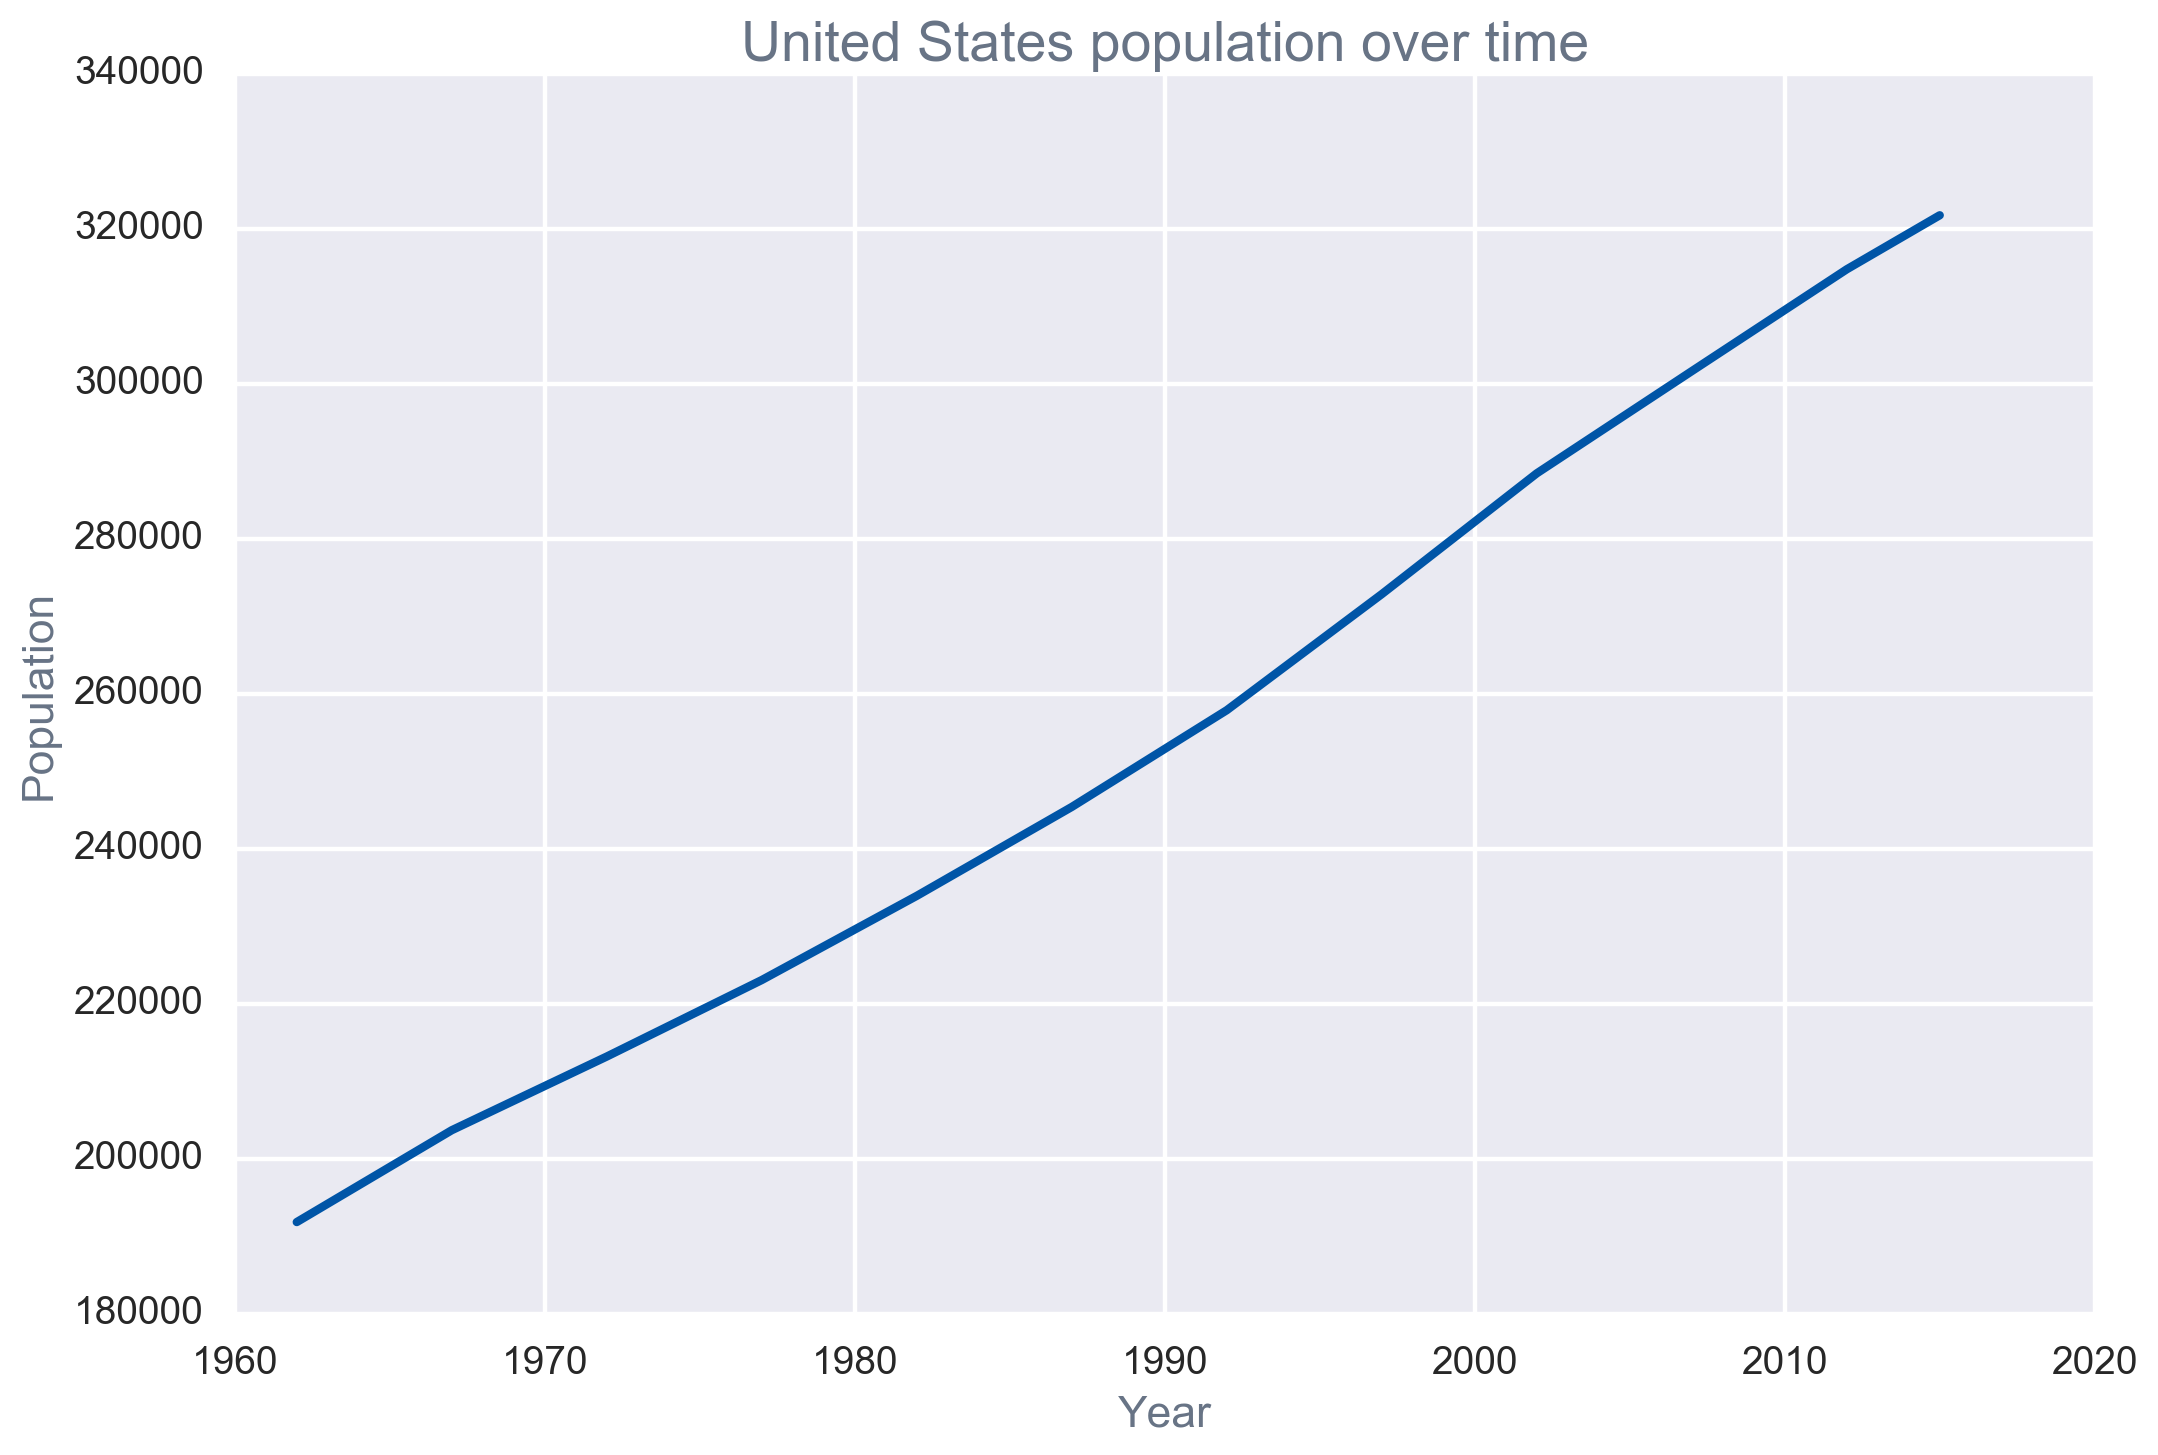

In [19]:
plt.plot(time_series(data, 'United States of America', 'total_pop'));
plt.xlabel('Year');
plt.ylabel('Population');
plt.title('United States population over time');


### One region 

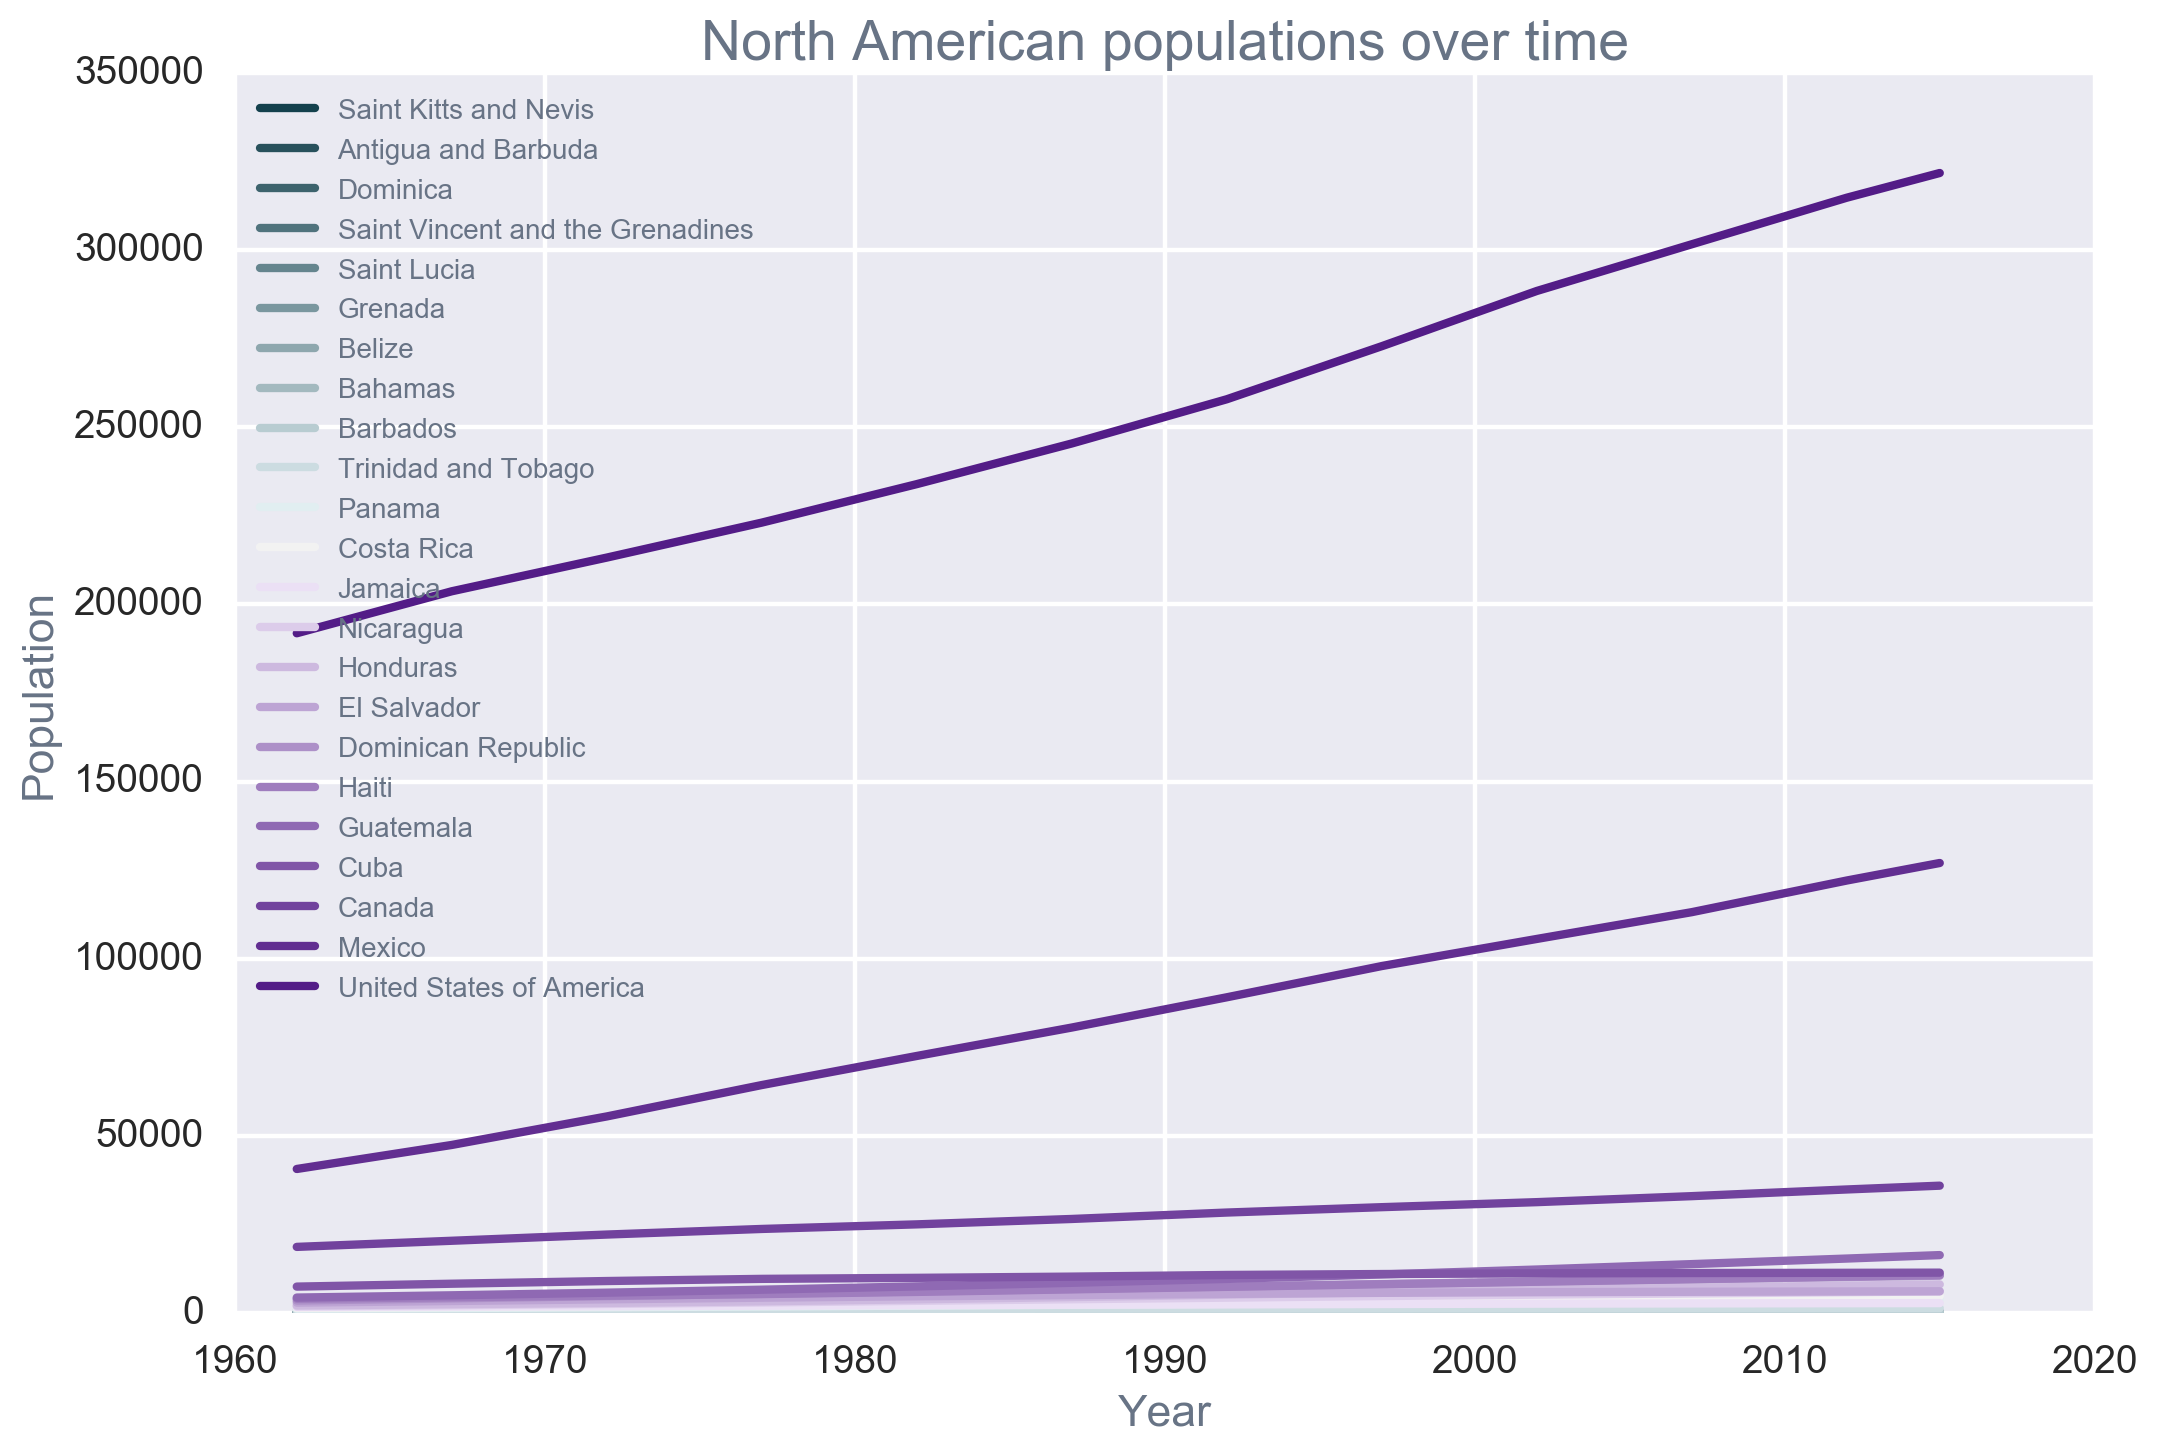

In [20]:
with sns.color_palette(sns.diverging_palette(220, 280, s=85, l=25, n=23)):
    north_america = time_slice(subregion(data, 'North America'), '1958-1962').sort_values('total_pop').index.tolist()
    for country in north_america:
        plt.plot(time_series(data, country, 'total_pop'), label=country);
        plt.xlabel('Year');
        plt.ylabel('Population');
        plt.title('North American populations over time');
    plt.legend(loc=2,prop={'size':10});


这除了北美洲是最大的国家之外，什么也没有告诉我们。我们想了解每个国家的人口是如何随着时间的推移而变化的，主要是参照自身的变化。

我们应该通过什么标准化？我们可以选择一个国家的最小、平均、中位数、最大值…或任何其他位置

让我们选择最小值，这样我们就能看到每个国家在起始人口上的增长。

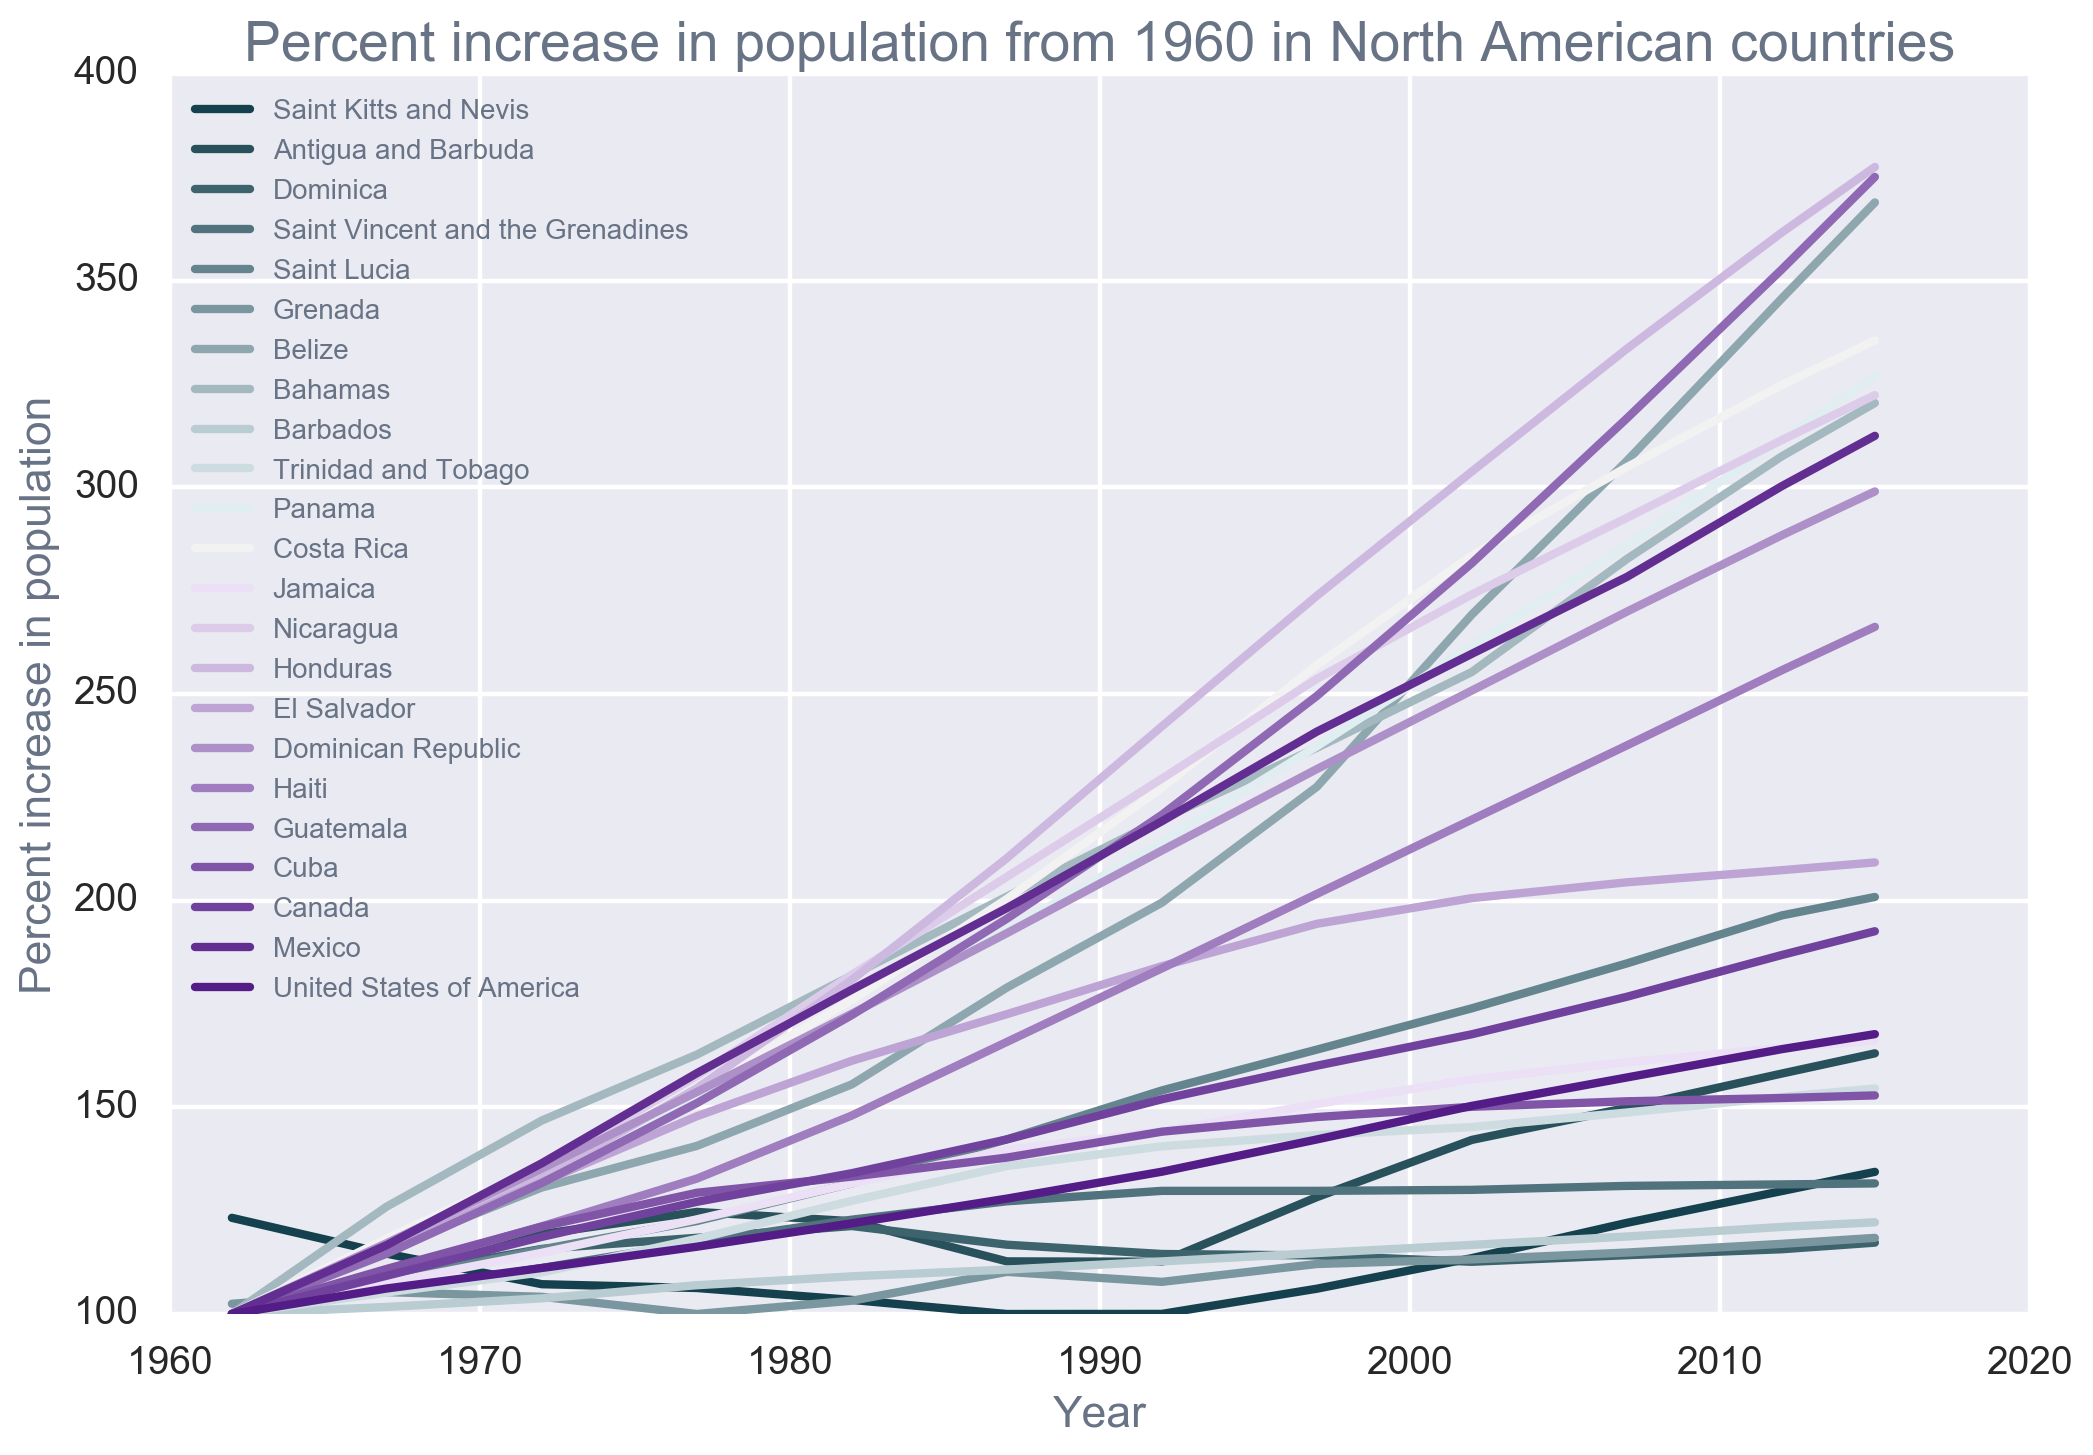

In [28]:
with sns.color_palette(sns.diverging_palette(220, 280, s=85, l=25, n=23)):
    for country in north_america:
        ts = time_series(data, country, 'total_pop')
        ts['norm_pop'] = ts.total_pop/ts.total_pop.min()*100
        plt.plot(ts['norm_pop'], label=country);
        plt.xlabel('Year');
        plt.ylabel('Percent increase in population');
        plt.title('Percent increase in population from 1960 in North American countries');
    plt.legend(loc=2,prop={'size':10});


There are too many lines here!  We should really only have 3-4 lines on a plot to be able to spot patterns. What we can see, however, is that *generally*, larger countries grow faster thatn smaller, with two main exceptions. But, we can't figure out which countries those are. Another option is a heatmap. 

In [29]:
north_america_pop = variable_slice(subregion(data, 'North America'), 'total_pop')
north_america_norm_pop = north_america_pop.div(north_america_pop.min(axis=1), axis=0)*100
north_america_norm_pop = north_america_norm_pop.loc[north_america]

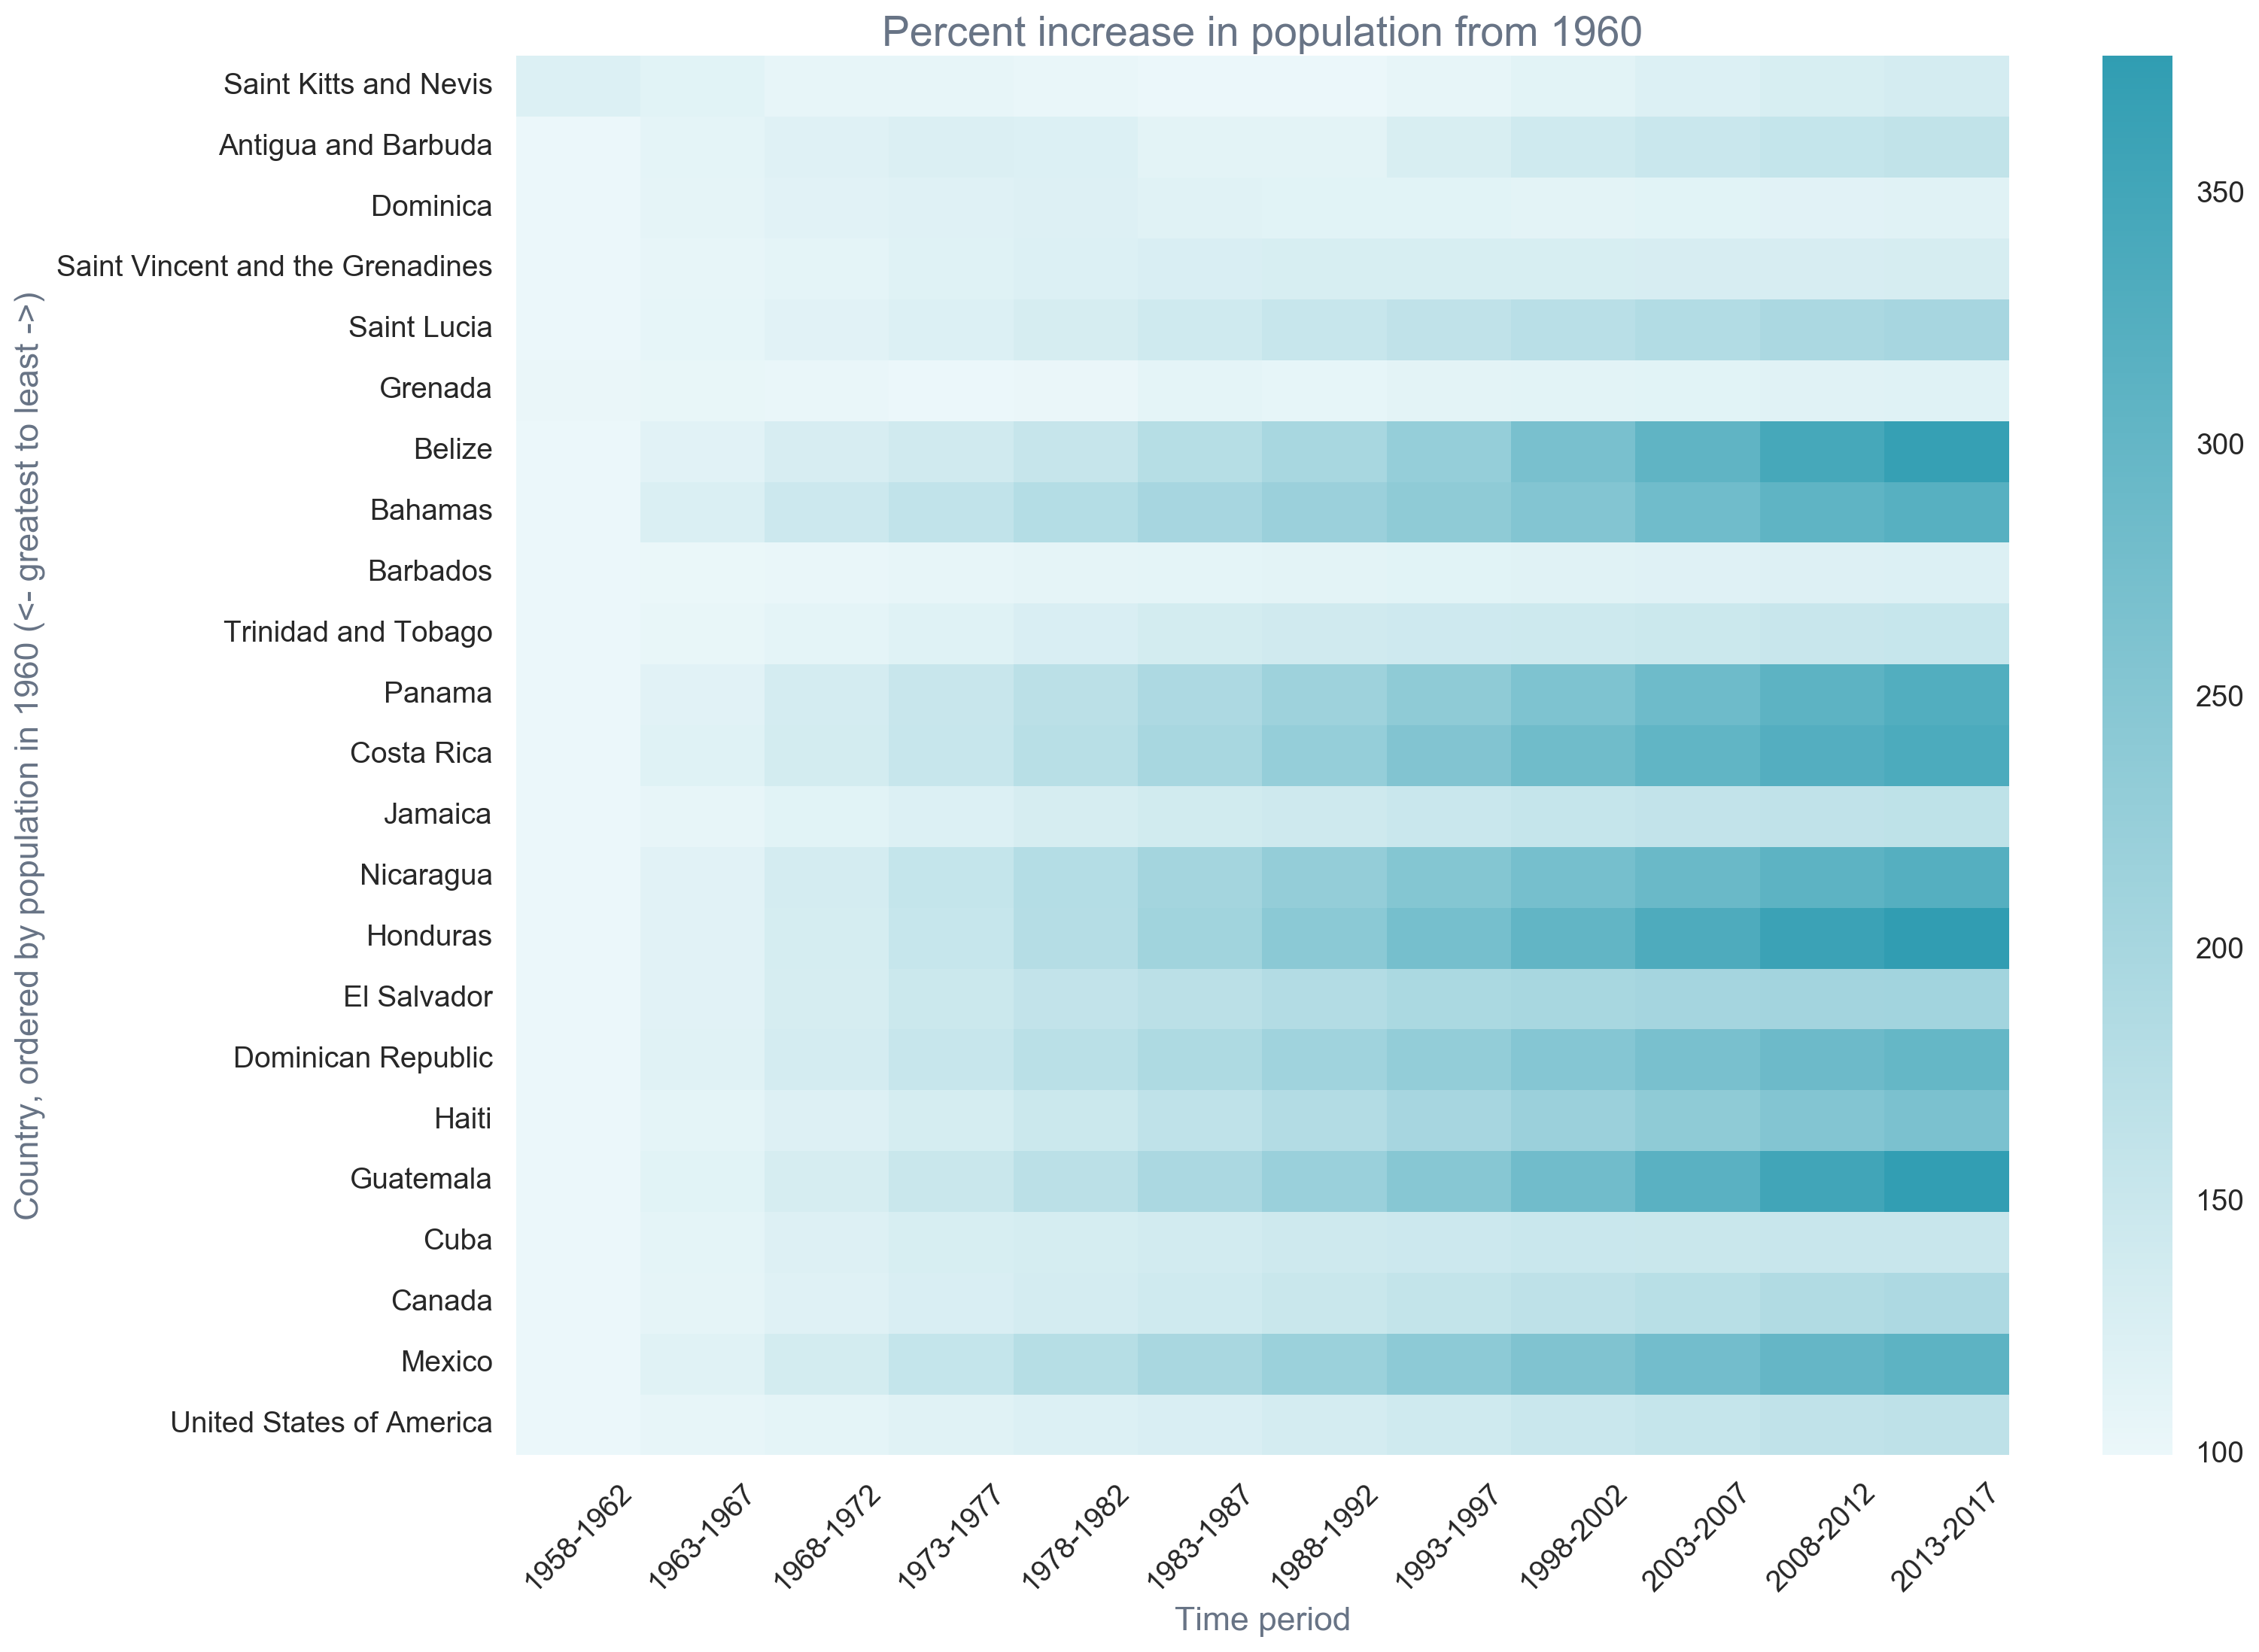

In [30]:
fig, ax = plt.subplots(figsize=(16, 12));
sns.heatmap(north_america_norm_pop, ax=ax, cmap=sns.light_palette((214, 90, 60), input="husl", as_cmap=True));
plt.xticks(rotation=45);
plt.xlabel('Time period');
plt.ylabel('Country, ordered by population in 1960 (<- greatest to least ->)');
plt.title('Percent increase in population from 1960');


## Exploring *total renewable water resources*

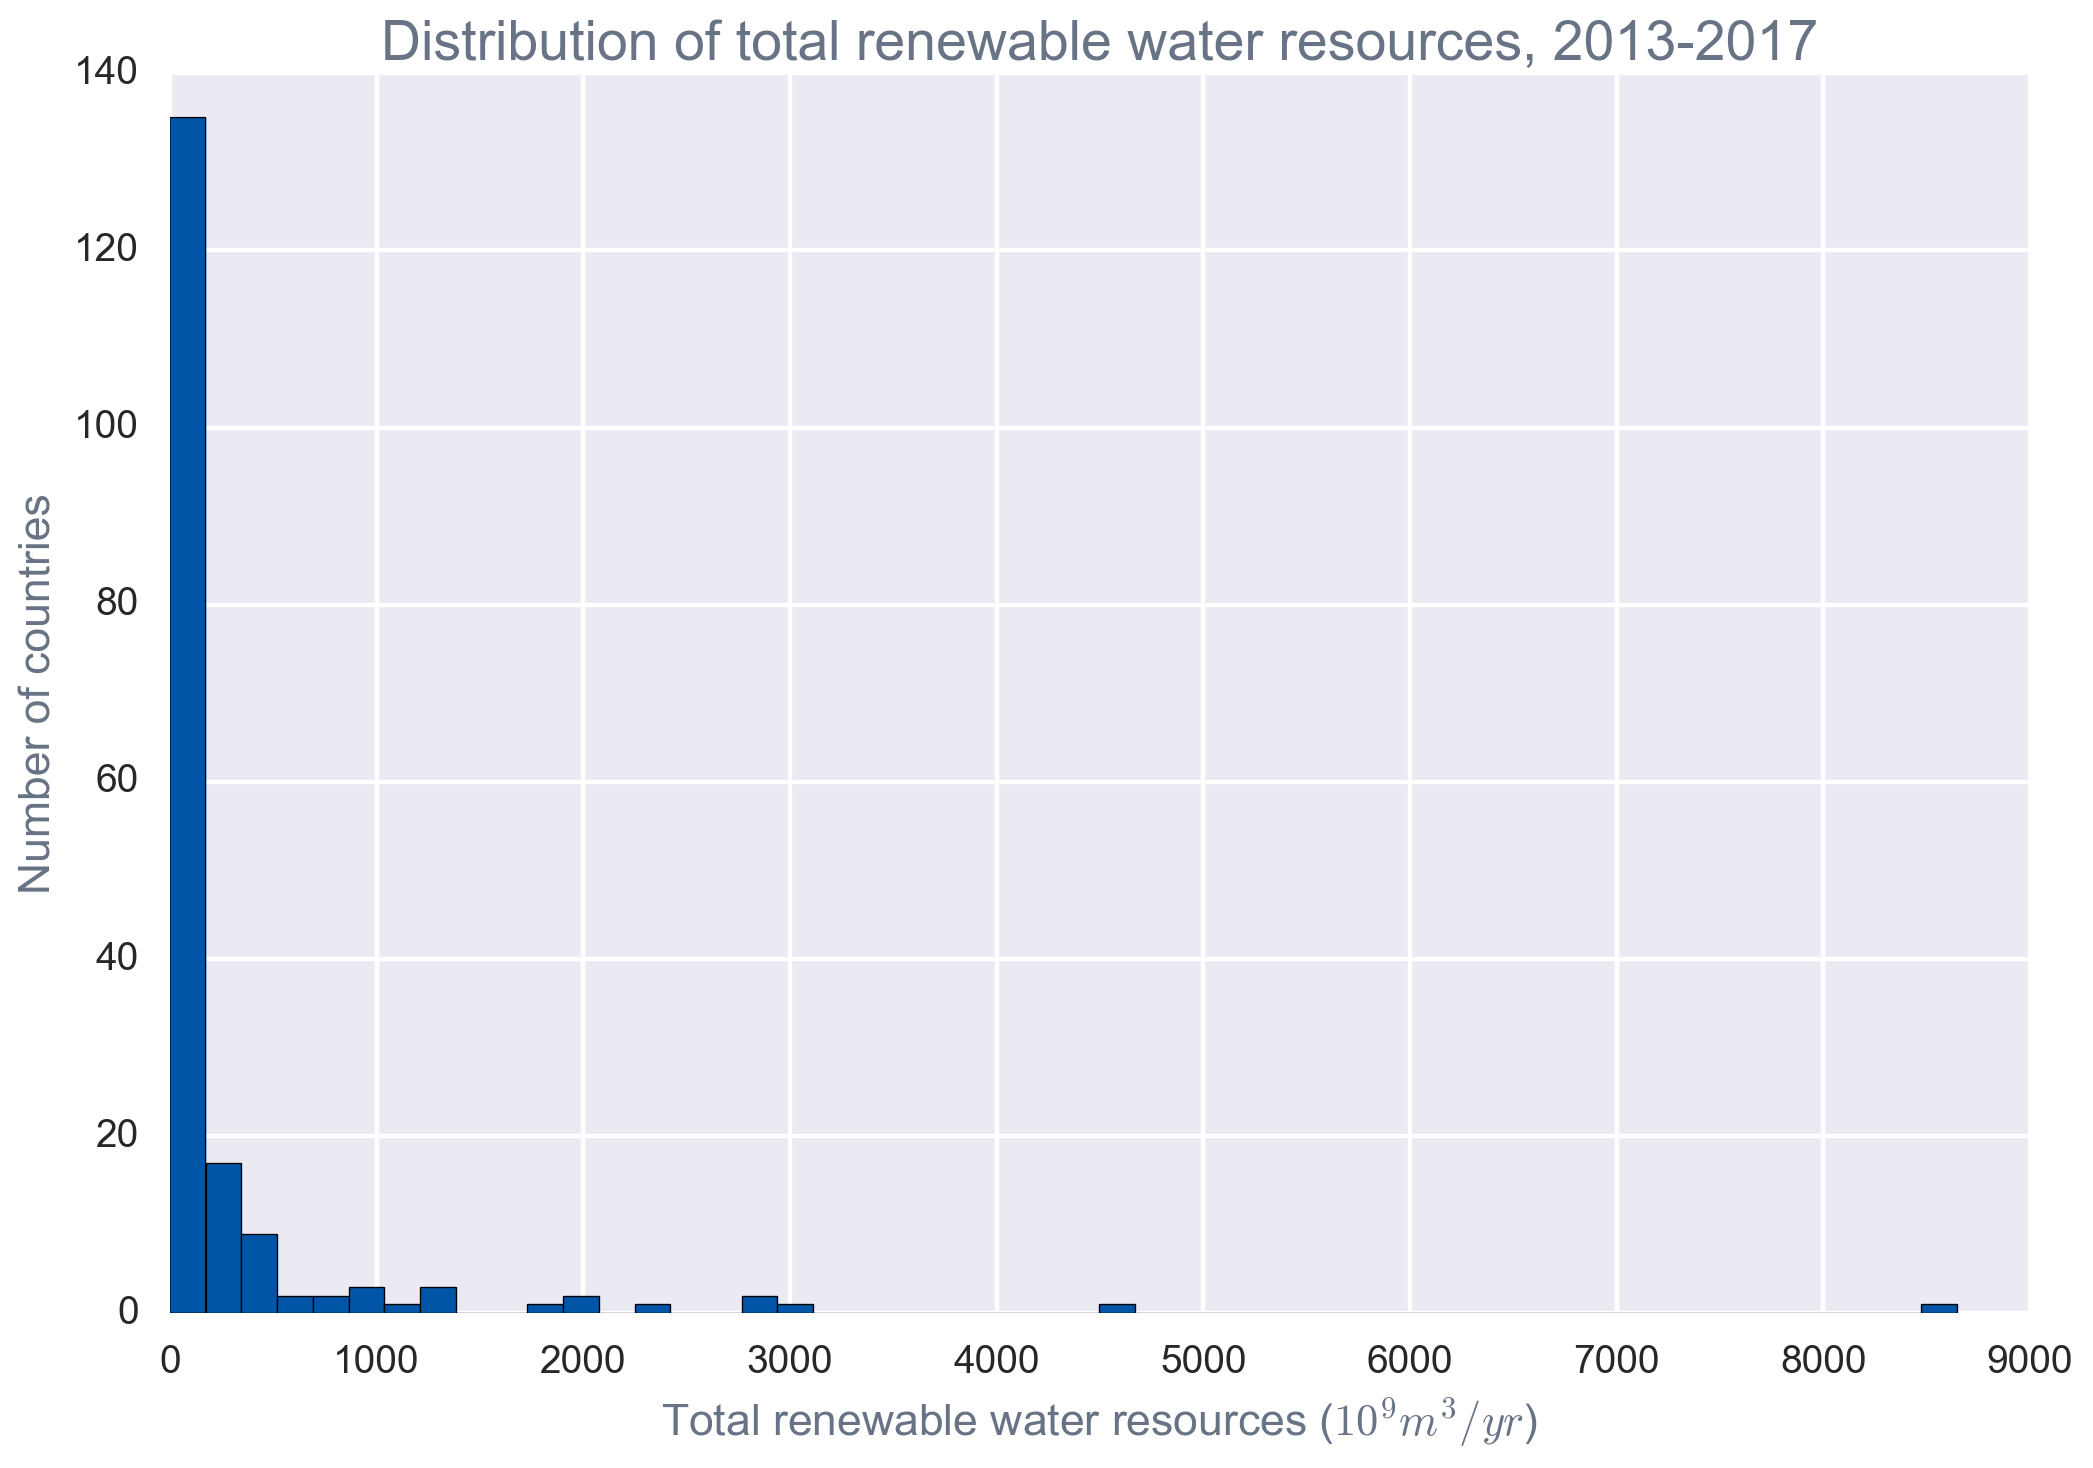

In [31]:
plot_hist(recent, 'total_renewable', bins=50, 
          xlabel='Total renewable water resources ($10^9 m^3/yr$)',
          ylabel='Number of countries', 
          title='Distribution of total renewable water resources, 2013-2017');

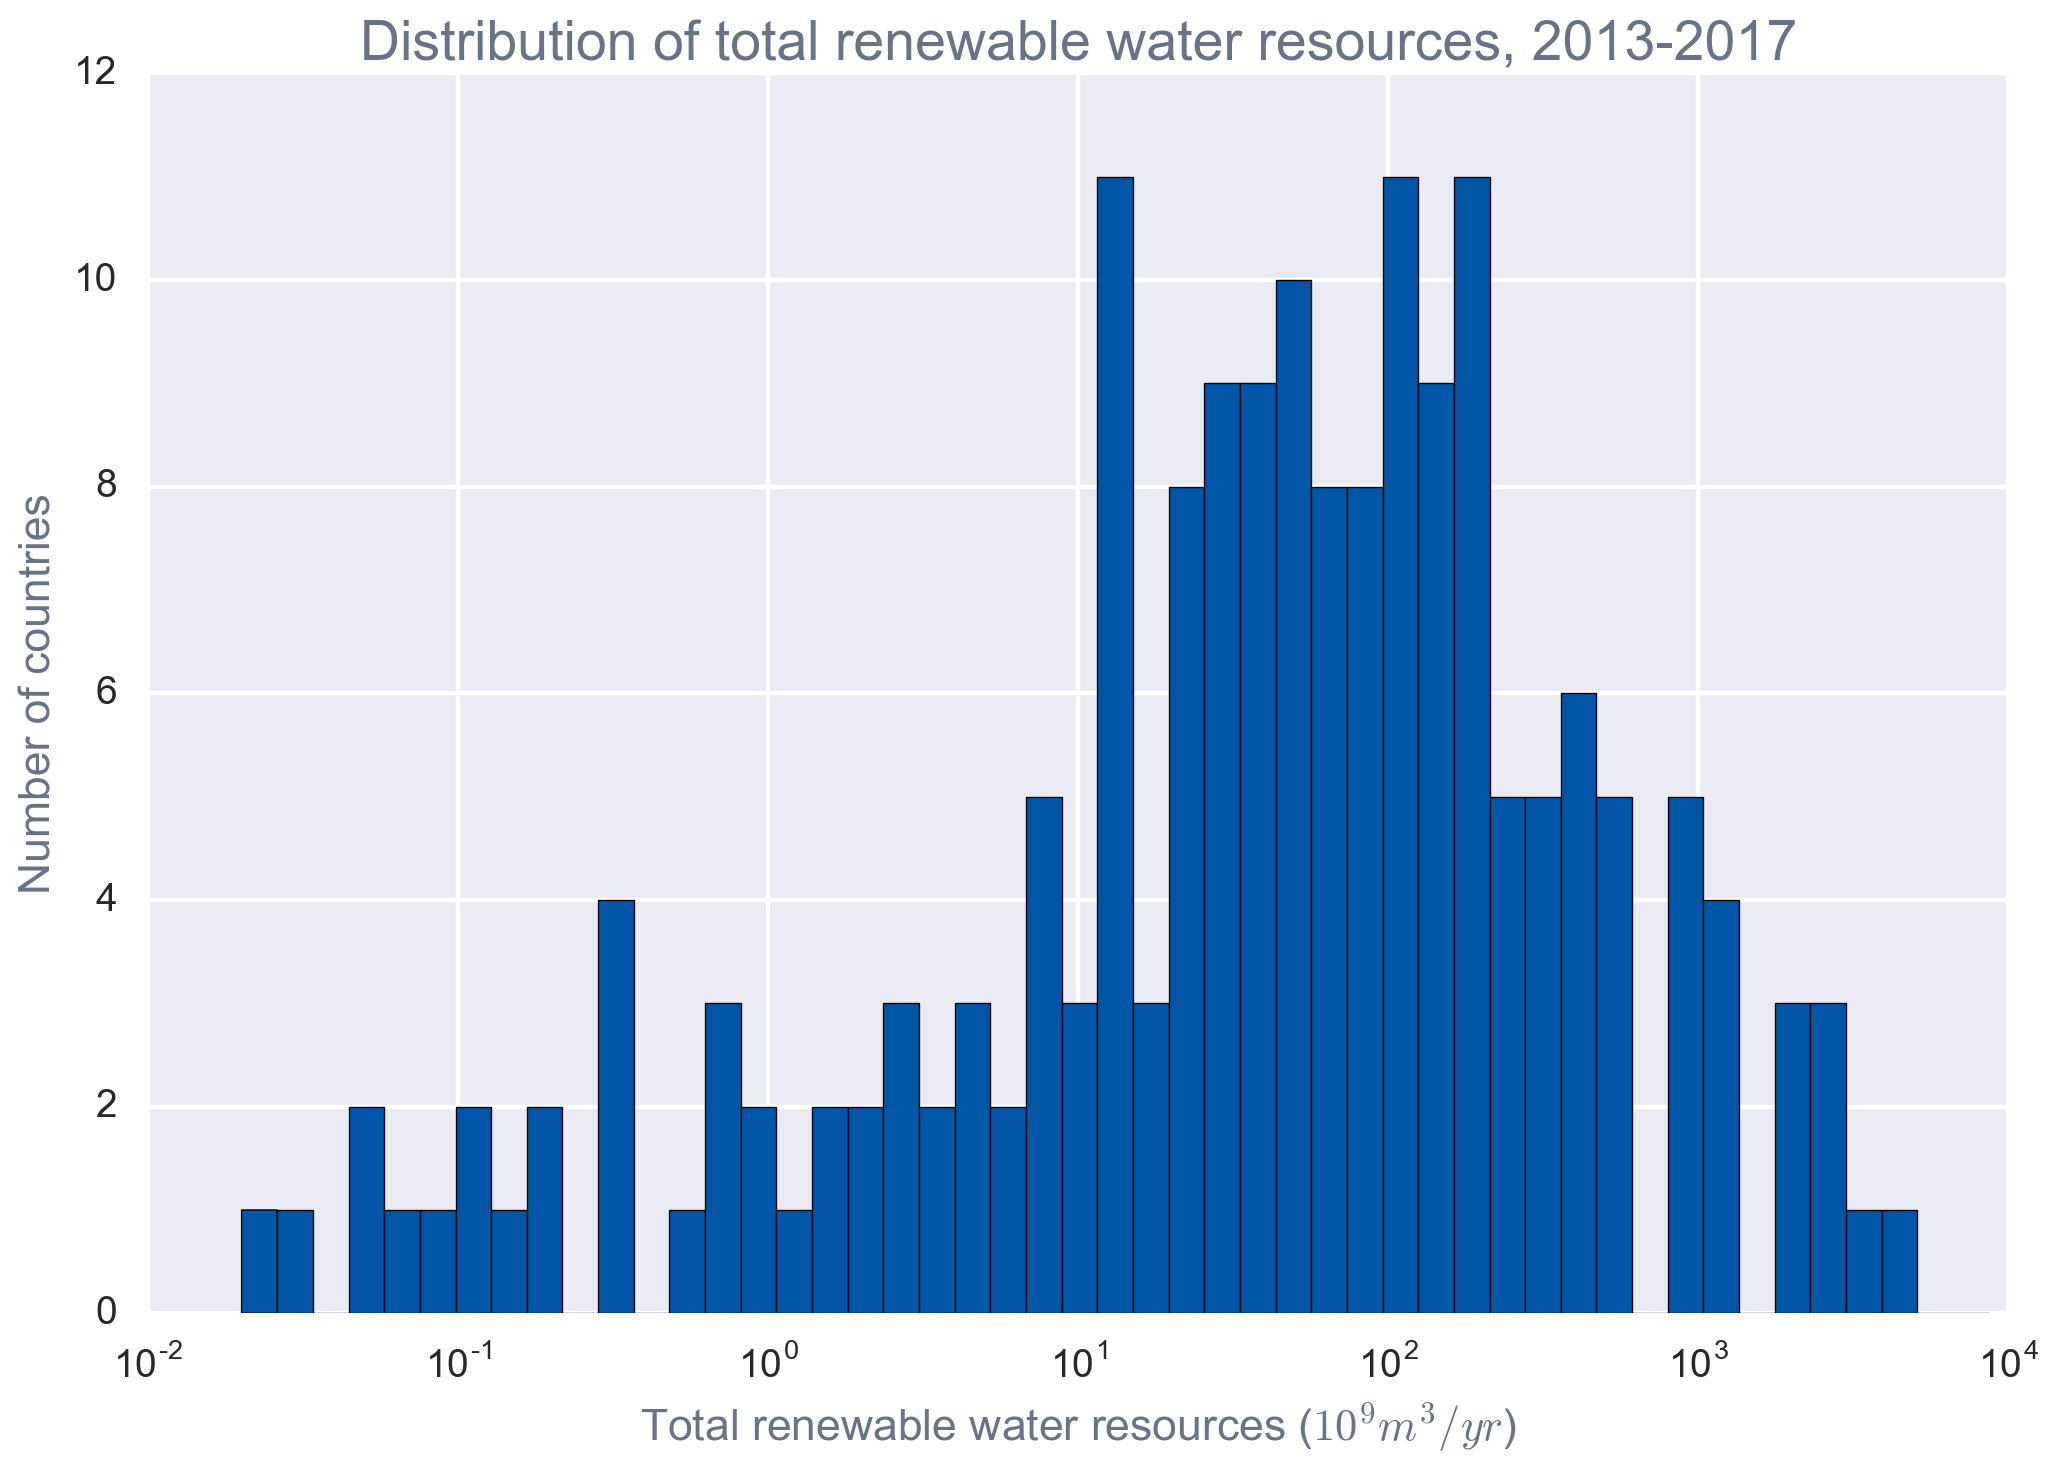

In [35]:
plot_hist(recent, 'total_renewable', bins=50, 
          xlabel='Total renewable water resources ($10^9 m^3/yr$)',
          ylabel='Number of countries', logx=True,
          title='Distribution of total renewable water resources, 2013-2017');

In [36]:
north_america_renew = variable_slice(subregion(data, 'North America'), 'total_renewable')

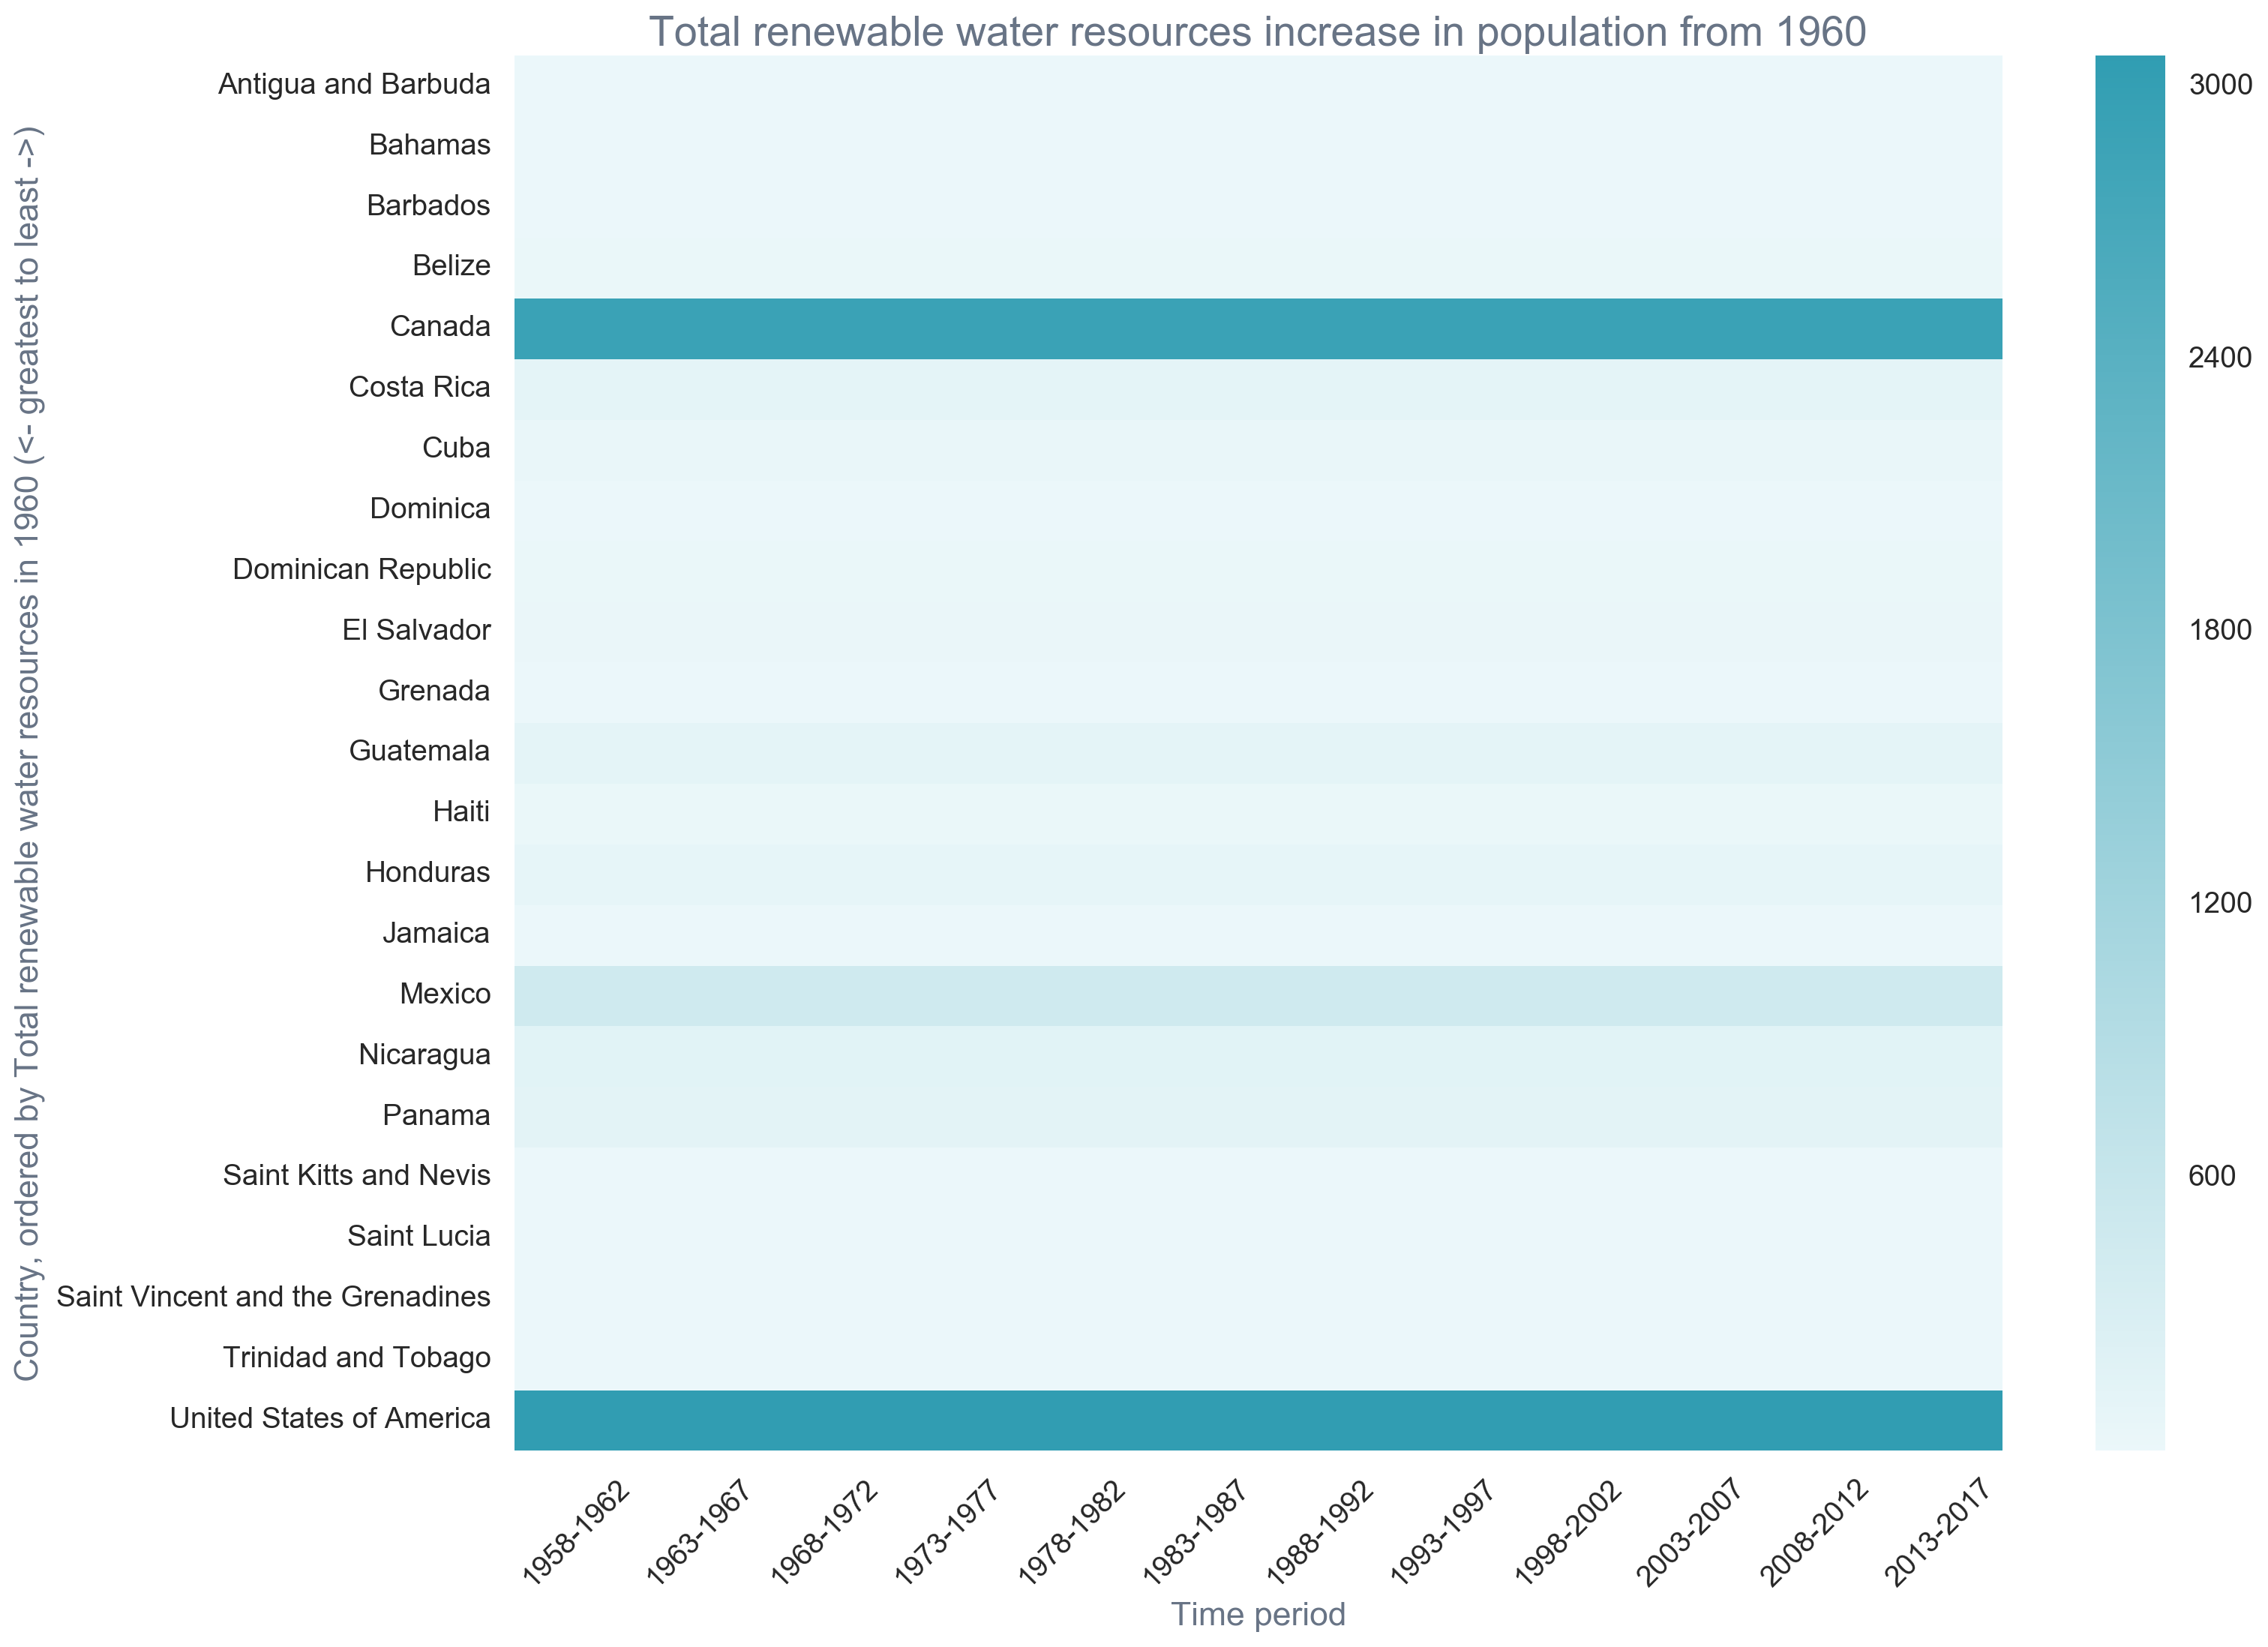

In [38]:
fig, ax = plt.subplots(figsize=(16, 12));
sns.heatmap(north_america_renew, ax=ax, cmap=sns.light_palette((214, 90, 60), input="husl", as_cmap=True));
plt.xticks(rotation=45);
plt.xlabel('Time period');
plt.ylabel('Country, ordered by Total renewable water resources in 1960 (<- greatest to least ->)');
plt.title('Total renewable water resources increase in population from 1960');


## Assessing many variables

In [33]:
def two_hist(df, variable, bins=50,
              ylabel='Number of countries', title=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
    ax1 = plot_hist(df, variable, bins=bins, 
                    xlabel=variable, ylabel=ylabel, 
                    ax=ax1, title=variable if not title else title)
    ax2 = plot_hist(df, variable, bins=bins, 
                    xlabel='Log of '+ variable, ylabel=ylabel, 
                    logx=True, ax=ax2, 
                    title='Log of '+ variable if not title else title)
    plt.close()
    return fig

In [34]:
def hist_over_var(df, variables, bins=50,
                  ylabel='Number of countries', title=None):
    
    variable_slider = widgets.Dropdown(options=variables.tolist(),
                                      value=variables[0],
                                      description='Variable:',
                                      disabled=False,
                                      button_style='')
    widgets.interact(two_hist, df=widgets.fixed(df), 
                     variable=variable_slider, ylabel=widgets.fixed(ylabel),
                     title=widgets.fixed(title), bins=widgets.fixed(bins));

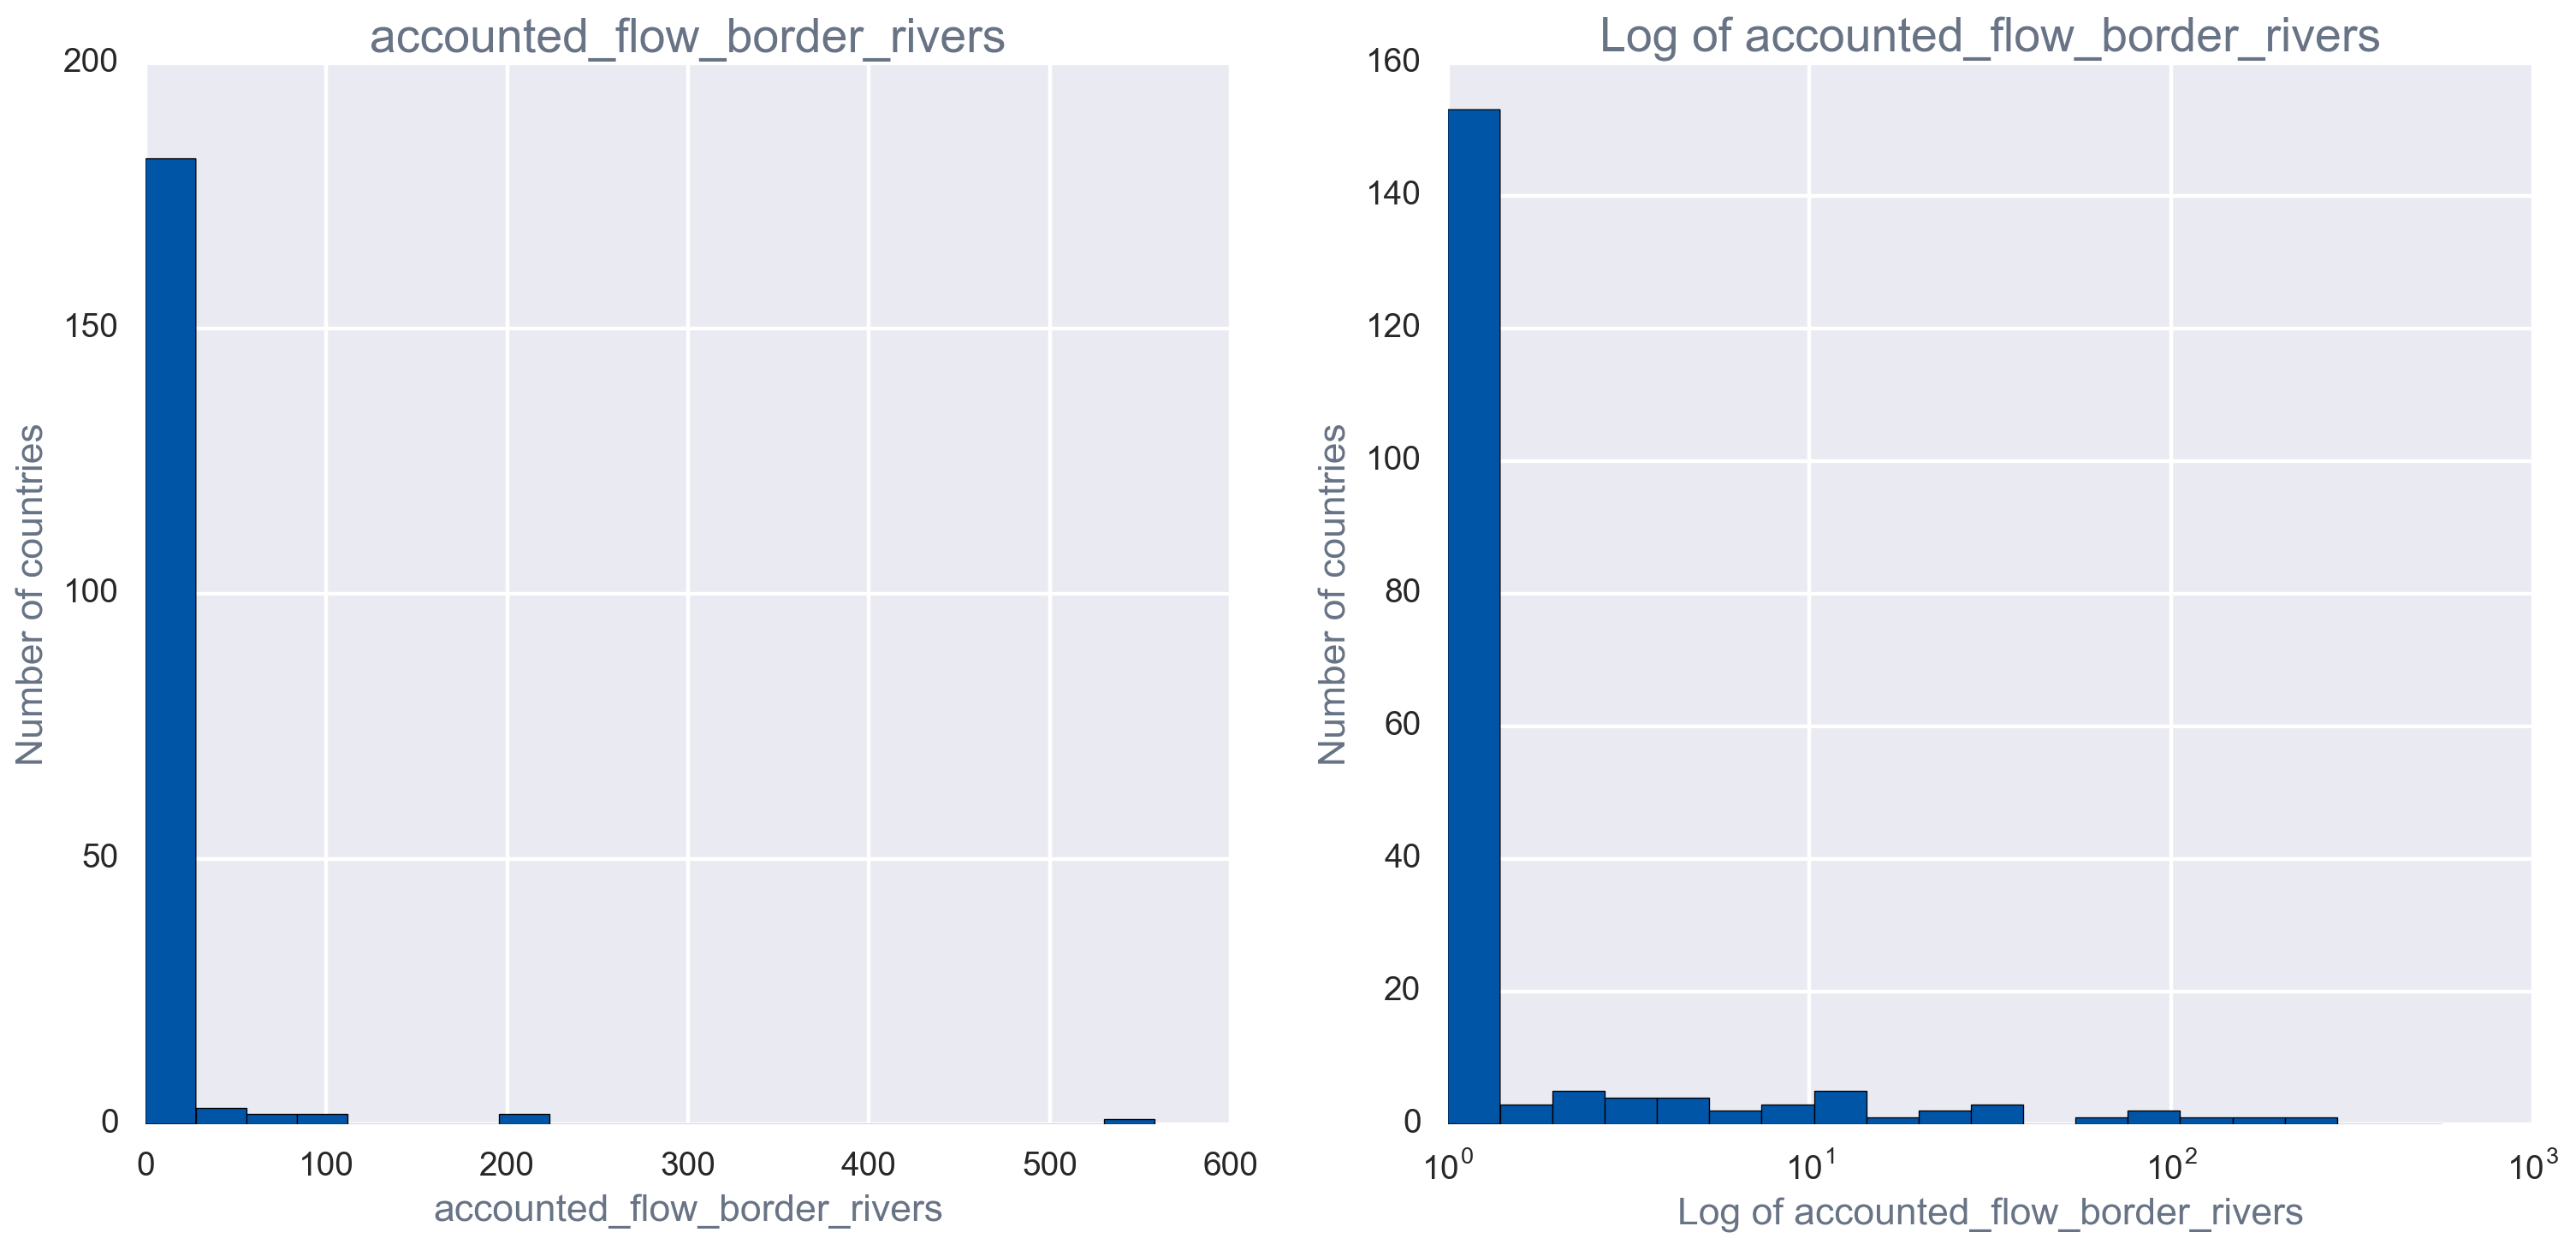

In [35]:
hist_over_var(recent, recent.columns, bins=20)